#### 작업내용

1. 20210426 수정사항\
1) 병리검사일 당일이나 하루 전에 수술을 시행했는가 (좀 더 세련되게 하는 방법은 병리검사와 수술에 공통의 신체부위명이 들어가 있는지 확인)\
2) cisplatin, mitomycin_c 단일 약제만 사용한 경우는 각 환장번호와 그 환자의 regimen line 결과를 정리한 dataframe인 regimen_df에 isCisMito column에 True값을 그렇지 않은 다른 모든 경우에는 False 값을 넣어서 저장


2. 20210427 수정사항\
1) immuno 약제도 regimen line 계산시 포함\
2) Immuno 환자군의 경우 regimen line이 chemo drug에 의한 것인지 immuno drug에 의한 것인지 Tagging 함\
3) chemo adjuvant는 6개월이상 하지 않지만 immuno adjuvant는 6개월 이상할 수 있음\
4) neo-adjuvant를 한 후 8주쯤 후에 수술하는 경우가 많음\
5) 완화적 (palliative) 치료 이후에는 neo-adjuvant가 나오는 일은 없음

3. 20210513 수정사항\
1) 나이는 탄생연월과 원발성암 최초선고일 사이의 기간으로 정의, 만약 원발성암 최초선고일이 없다면 첫번째 진료기록일을 대체
2) 최대빈도암이 기타암일 때 기타암이 아닌 다른 암을 진단하는 날짜와 최초 기타암을 선고하는 날짜 사이의 간격을 살펴보면 루틴 제거
3) 기타암이 최대빈도암일 때 기타암이 아닌 다른 암을 원발성 암으로 정하는 함수를 기존에는 chemo regimen diagram plot에서 사용하였으나 현재 immuno regimen diagram plot과 main 함수에서 subdirname을 정하는 과정에서도 반영

4. 20210520 수정사항\
1) Q1. 면역항암제 "투여기간"동안 나타나는 부작용은 어떤 것이 있을까?\
    (1) regimen ith line이 시작한 후 regimen (i+1)th line이 시작하기 전 기간을 연구기간을 볼 것인가? obsterm2close\
    (2) regimen ith line이 시작한 후 regimen ith line 투약을 끝나는 날을 연구기간으로 볼 것인가? obsterm1close\
    (3) regimen ith line이 시작한 후 last F/U까지 연구기간으로 볼 것인가? obsterm3close\
    (4) 이 과정에서는 sex, cancer_type, age, 그리고 regimen line은 반드시 일치시킬 것\
    (5) regimen_drugtype_term_details\
2) Q2. 면역항암제 투여기간이 지나서도 나타나는 부작용은 어떤 것이 있을까? \
    (1) io 항암제를 가장 마지막 regimen에 쓴 경우를 Treatment로 삼고 그와 일치하는 regimen의 개수에서 chemo를 쓴 환자의 경우를 control로 비교하는 연구임\
    (2) person_total 변수에 들어있는 정보면 충분할 듯 함\
    
5. 20210529 수정사항\
1) nrls (자세한 weekly regimen 정보가 들어있는 DF인데 때때로 초기 설정되어 있는 regimen에서 0th line이 없다면 최초항암제 투약 하루전일로 0th line을 입력해주어서 regimen 가짓수를 세는 데 모든 환자에 대해서 일관된 기준을 만들어 주기 위함 즉 어떤 환자는 patho나 adjuvant가 존재해서 0th regimen이 존재하지만 그렇지 않고 1부터 시작하는 nrls df를 가지는 경우도 많은데 이럴 경우 무조건 최초 항암제 투여일 전에 0th line을 삽입하는 것\
2) 결국 하고자 하는 일은, 만약 nrls의 rgmline 칼럼의 0, 2, 4, 5의 unique한 regimen line으로 존재한다면 이를 0, 1, 2, 3으로 변경해 주기 위함이다. \

6. 20210601 수정사항\
1) gefitinib,medi4736 두 약을 regimen을 쓰는 경우 medi4736은 매주 1회씩 투여하지만 gefitinib은 1달에 한번 정도 투약하는 패턴을 가지는데 현재 알고리즘상으로는 직전 3개의 history만 기억을 하기 때문에 새로운 약이 들어온 것으로 파악하게 된다. 따라서 이 경우는 사후적으로 처리를 해 줄 필요가 있다고 보여진다. 이 경우 한 Regimen에서 사용한 약을 모두 합집합으로 묶어서 만약 연속된 regimen이 같은 약만을 사용할 경우 이를 하나의 regimen으로 재분류할 필요성이 있다. \
2) 현재 regimen 종료일(terminal date)을 해당 regimen의 항암제를 마지막으로 투여한 날로 하였는데 하루만에 종료되지 않는 약도 있다. 특히 chemo 항암제의 경우 이럴  경우 regimen 종료일을 마지막 항암제 투여 종료일로 변경해 주어야한다. drug_exposure_end_date\
    
#### Bugs
1. 항암제 조합이 eciine,aldesleukin일 때 aldesleukin,eciine 이면, 서로 다른 regimen으로 인식하는데 이를 수정해야 함

In [1]:
import sys, os, re, shutil
import numpy as np
import pandas as pd

#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.unicode_minus'] = False

from cycler import cycler
from tqdm import tqdm

import itertools
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 1000)

In [2]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

nanum_font_list = fm.findSystemFonts(fontpaths='/usr/share/fonts/truetype/nanum/')

for font in nanum_font_list:
    print(f"Name: {fm.FontProperties(fname=font).get_name()} | Path: {font}")

버전:  3.3.4
설치 위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
설정 위치:  /home/hahnyi/.config/matplotlib
캐시 위치:  /home/hahnyi/.cache/matplotlib
Name: NanumSquare | Path: /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
Name: NanumMyeongjo | Path: /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
Name: NanumBarunGothic | Path: /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
Name: NanumSquareRound | Path: /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
Name: NanumMyeongjo | Path: /usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
Name: NanumGothic | Path: /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
Name: NanumSquareRound | Path: /usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
Name: NanumBarunGothic | Path: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
Name: NanumSquare | Path: /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
Name: NanumGothic | Path: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [3]:
fm.get_fontconfig_fonts()
font_path = "/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf"
font_prop = fm.FontProperties(fname=font_path)

In [4]:
%run "common.ipynb"

(5328, 21)
(1811,)
Index(['person_id', 'gender_concept_id', 'year_of_birth', 'month_of_birth',
       'day_of_birth', 'birth_datetime', 'race_concept_id',
       'ethnicity_concept_id', 'location_id', 'provider_id', 'care_site_id',
       'person_source_value', 'gender_source_value',
       'gender_source_concept_id', 'race_source_value',
       'race_source_concept_id', 'ethnicity_source_value',
       'ethnicity_source_concept_id', 'obfl', 'matchfl', 'one_on_two'],
      dtype='object')
code_full(drug_code_full.csv):  (5468, 6)
ccode_cancer(cancer_treatment_drug.csv):  (485, 10)
code_add(drug_code_add.csv):  (172, 10)
code_full(drug_code_full.csv):  (5468, 6)
ccode_cancer(cancer_treatment_drug.csv):  (485, 10)
code_add(drug_code_add.csv):  (172, 10)


In [5]:
data_home_path = "/workspace/data/"

In [6]:
#수술 리스트 입력
op_map_complete = pd.read_excel(os.path.join(data_home_path, 
                       "diagnose_operation_concept_id_mapping_list20210330_from_SeyoungSeo.xlsx"), 
                        sheet_name='수술')
#print(op_map_complete.shape)
# concept_id 중복된 행 제거
op_map_complete = op_map_complete.drop_duplicates(subset='concept_id', keep='first')
#print(op_map_complete.shape)
op_map = pd.read_excel(os.path.join(data_home_path, 
                                    "diagnose_operation_concept_id_mapping_list20210330_from_SeyoungSeo.xlsx"), 
                       sheet_name='수술')
# including only operation containing keywords
op_map.loc[:, '수술코드명'] = op_map['수술코드명'].str.lower()
op_map = op_map[op_map['수술코드명'].str.contains(
                    'tomy|operation|excision|surgery|resection')&
               ~op_map['수술코드명'].str.contains(
                   'scop|scan|monitor|stereo|computerized|graph|biopsy|gram|radiosurgery|explorat')]
# concept_id 종북된 행 제거
op_map = op_map.drop_duplicates(subset='concept_id', keep='first')
#print(op_map.shape)
# 제외된 수술의 리스트
drug_map_excluded = op_map_complete[~op_map_complete['concept_id']\
                                       .isin(op_map['concept_id'])]
drug_map_excluded.to_excel("excluded_procedures.xlsx", sheet_name='excluded')
#print (drug_map_excluded.shape)

In [7]:
op_map.head(900)

,수술코드,수술코드명,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code
19,1,"incision and excision of skull, brain, and cerebral meninges",4233946,Operative procedure on head,Procedure,SNOMED,Procedure,S,89901005
32,12,craniotomy and craniectomy,4210457,Operation on bone of skull,Procedure,SNOMED,Procedure,S,56222002
35,123,reopening of craniotomy site,4307677,Reopening of craniotomy site,Procedure,SNOMED,Procedure,S,82917000
36,124,other craniotomy,4101626,Craniotomy,Procedure,SNOMED,Procedure,S,25353009
37,125,other craniectomy,4281936,Craniectomy,Procedure,SNOMED,Procedure,S,36910002
40,132,lobotomy and tractotomy,4298092,Lobotomy and tractotomy,Procedure,SNOMED,Procedure,S,76961002
42,14,operations on thalamus and globus pallidus,4323283,Operation on brain,Procedure,SNOMED,Procedure,S,70586009
43,141,operations on thalamus,4119228,Operation on thalamus,Procedure,SNOMED,Procedure,S,287208004
44,142,operations on globus pallidus,4211527,Operation on globus pallidus,Procedure,SNOMED,Procedure,S,56959007
46,151,excision of lesion or tissue of cerebral meninges,4099019,Excision of lesion of cerebral meninges,Procedure,SNOMED,Procedure,S,27190002


In [8]:
procedure_df = pd.merge(procedure_pd, op_map, how='left', 
                       left_on='procedure_concept_id',
                       right_on='concept_id')
# 선택된 키워드를 포함하고 있는 기록만 선택
procedure_df = procedure_df[procedure_df['concept_id'].notnull()]

In [9]:
# 2021/04/27
amis2_proc = pd.read_excel(os.path.join(data_home_path, 
                                       "AMIS3.0_procedure_code_chart_ASIS-TOBE_code_5-3.xlsx"),
                           sheet_name='5-3', skiprows=3)
amis2_proc.loc[:, '2.0 처방코드 영문명'] = amis2_proc['2.0 처방코드 영문명'].str.lower()
amis2_anesth = amis2_proc[amis2_proc['2.0 처방코드 한글명'].str.contains('전신마취', regex=False, na=False)|
                         amis2_proc['2.0 처방코드 한글명'].str.contains('흡입마취', regex=False, na=False)]
# 처방코드가 중복된 것들은 모두 삭제
amis2_anesth = amis2_anesth.drop_duplicates(subset='2.0 처방코드', keep='first')
amis2_anesth.to_excel("anesth_amis2.0.xlsx", index=False)

In [10]:
procedure_pd.shape

(862688, 14)

In [11]:
procedure_pd[procedure_pd['procedure_concept_id']==4118897]

,procedure_occurrence_id,person_id,procedure_concept_id,procedure_date,procedure_datetime,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value


In [12]:
# 2021/04/27
anesth_df = pd.merge(procedure_pd, amis2_anesth, how='left', 
                       left_on='procedure_source_value',
                       right_on='2.0 처방코드')
print(anesth_df.head(20))
# concept_id가 Null 인 것은 모두 제외한다. 우리가 선택한 keywords를 가진 병리조직검사만 2.0 처방코드를 가진다. 
#그림을 그리는데 불필요한 procedure 정보가 들어와 가로축의 범위를 넓혀 그림을 이해하기 어렵게 만든다.
anesth_df = anesth_df[anesth_df['2.0 처방코드'].notnull()]
print(anesth_df.columns)
anesth_df.shape

    procedure_occurrence_id  person_id  procedure_concept_id procedure_date  \
0                       262         22             4063911.0     2010-01-05   
1                      1197         23             4063911.0     2010-01-12   
2                      2674         23             4144452.0     2010-01-22   
3                      2675         23             4068181.0     2010-01-22   
4                      3121         24             4181300.0     2010-01-27   
5                      6103         15             4294382.0     2010-02-20   
6                      6104         15             4181300.0     2010-02-20   
7                      6758         21                   NaN     2010-02-25   
8                      6759         21                   NaN     2010-02-25   
9                      6760         21             4181300.0     2010-02-25   
10                     7905         23             4144452.0     2010-03-05   
11                     7906         26             4

(0, 26)

In [13]:
# 2021/04/27
# including only procedures containing keywords
amis2_proc = pd.read_excel(os.path.join(data_home_path, 
                                       "AMIS3.0_procedure_code_chart_ASIS-TOBE_code_5-3.xlsx"),
                           sheet_name='5-3', skiprows=3)
amis2_proc.loc[:, '2.0 처방코드 영문명'] = amis2_proc['2.0 처방코드 영문명'].str.lower()
amis2_patho = amis2_proc[amis2_proc['2.0 처방코드 한글명'].str.contains('병리', regex=False, na=False) &
                       amis2_proc['2.0 처방코드 한글명'].str.contains('암조직', regex=False, na=False) &
                       ~amis2_proc['2.0 처방코드 한글명'].str.contains('침', regex=False, na=False) &
                       ~amis2_proc['2.0 처방코드 한글명'].str.contains('면역효소조직화학', regex=False, na=False)]
# 처방코드가 중복된 것들은 모두 삭제
amis2_patho= amis2_patho.drop_duplicates(subset='2.0 처방코드', keep='first')
amis2_patho['2.0 처방코드 영문명'].head(40)

4711                             adrenal gland cancer
4712      adrenal gland cancer (ln 20개이상,block 40개이상)
4784    common bile duct cancer (ln 20개이상,block 40..)
4790                    extrahepatic bile duct cancer
4812                                      bone cancer
4824                               spinal bone cancer
4829                            bone cancer (mapping)
4854                               breast cancer (lt)
4866                                    breast cancer
4867             breast cancer (ln 20개이상,block 40개이상)
4869                               breast cancer (rt)
4946                                 esophagus cancer
4978                                   eyeball cancer
5004                                   salpinx cancer
5005                        salpinx cancer (ln 20개이상)
5018                               gallbladder cancer
5045                                   pharynx cancer
5120                                    kidney cancer
5144                        

In [14]:
patho_df = pd.merge(procedure_pd, amis2_patho, how='left', 
                       left_on='procedure_source_value',
                       right_on='2.0 처방코드')
# concept_id가 Null 인 것은 모두 제외한다. 우리가 선택한 keywords를 가진 병리조직검사만 2.0 처방코드를 가진다. 
#그림을 그리는데 불필요한 procedure 정보가 들어와 가로축의 범위를 넓혀 그림을 이해하기 어렵게 만든다.
patho_df = patho_df[patho_df['2.0 처방코드'].notnull()]
print(patho_df.columns)
patho_df.shape

Index(['procedure_occurrence_id', 'person_id', 'procedure_concept_id',
       'procedure_date', 'procedure_datetime', 'procedure_type_concept_id',
       'modifier_concept_id', 'quantity', 'provider_id', 'visit_occurrence_id',
       'visit_detail_id', 'procedure_source_value',
       'procedure_source_concept_id', 'modifier_source_value', '행위\n차수',
       '2.0 테이블명', '2.0 처방코드', '2.0 처방코드 영문명', '2.0 처방코드 한글명', '2.0 연결\n물품코드',
       '3.0\n기준정보', '3.0 대체코드', '3.0 대체코드 영문명', '3.0 대체코드 한글명',
       '3.0\n대체코드\n유효성', '3.0 대체행위코드 종료사유'],
      dtype='object')


(2377, 26)

#### 면역항암제군과 화학항암제군 성분명을 합칠 때 isImmuno feature를 추가하여 약의 범주 구분 가능

In [15]:
immuno_drug['isImmuno'] = True
chemo_drug['isImmuno'] = False

In [16]:
all_drug = pd.concat([chemo_drug, immuno_drug], axis=0)

In [17]:
drug_df = pd.merge(drug_pd.drop_duplicates(), all_drug.drop_duplicates(), 
                   how='left', left_on=['drug_source_value'], right_on=['code'])
# 면역항암제와 화학항암제가 아닌 경우는 투약 리스트에서 제거
drug_df = drug_df[drug_df['code'].notnull()]
drug_df.shape

(162226, 26)

In [18]:
drug_df.columns

Index(['drug_exposure_id', 'person_id', 'drug_concept_id',
       'drug_exposure_start_date', 'drug_exposure_start_datetime',
       'drug_exposure_end_date', 'drug_exposure_end_datetime',
       'verbatim_end_date', 'drug_type_concept_id', 'stop_reason', 'refills',
       'quantity', 'days_supply', 'sig', 'route_concept_id', 'lot_number',
       'provider_id', 'visit_occurrence_id', 'visit_detail_id',
       'drug_source_value', 'drug_source_concept_id', 'route_source_value',
       'dose_unit_source_value', 'code', 'name', 'isImmuno'],
      dtype='object')

In [19]:
drug_df.loc[:, 'name'] = drug_df['name']\
                            .apply(lambda x: re.sub(r'\(임상약\)|\(\?+\)', '', x.strip('\n')))
drug_df.loc[:, 'name'] = drug_df['name'].str.strip()
drug_df.loc[:, 'name'] = drug_df['name'].str.lower()
drug_df.loc[:, 'name'] = drug_df['name'].str.replace(r'\[[^]]*\]','')
drug_df.loc[:, 'name'] = drug_df['name'].str.replace(r'[0-9]+mg','')
drug_df.loc[:, 'name'] = drug_df['name']\
                             .apply(lambda x: re.sub(r'tab\.*|inj\.*|cap\.*', '', x.strip('')))
drug_df.loc[:, 'name'] = drug_df['name'].str.replace('diluent for ','')
drug_df.loc[:, 'name'] = drug_df['name'].str.replace('dbl ','')
drug_df.loc[:, 'name'] = drug_df['name'].str.replace('\(yuhan\)|kyowa','')
drug_df.loc[:, 'name'] = drug_df['name'].str.replace('evrolimus', 'everolimus')
drug_df.loc[:, 'name'] = drug_df['name']\
                             .apply(lambda x: re.sub(r'^ *| *$', '', x.strip('')))
drug_df.loc[:, 'name'] = drug_df['name'].str.replace(' ', '_')
drug_df[drug_df['isImmuno'] == True]['name'].value_counts().sort_index().to_csv("drug_short.csv")

In [20]:
def enum(s) :
    bgn, ter = re.search(r'C([0-9]+)-C([0-9]+)', s).groups()
    return ",".join(['C'+str(x).zfill(2) for x in range(int(bgn), int(ter)+1)])

In [21]:
def digitize(x) :
    if re.search(r',', x) :
        cancers = x.split(",")
        cancer_enum = []
        for cancer in cancers :
            if re.search(r'-', cancer) :
                cancer_enum.append(enum(cancer))
            else :
                cancer_enum.append(cancer)
        return ",".join(cancer_enum)
    elif re.search(r'-', x) :
        return enum(x)
    else :
        return x

In [22]:
cancer_type = pd.read_csv("cancer_types.tsv", sep="\t")
cancer_type['enum'] = cancer_type['표준진단코드'].apply(digitize)
cancer_type

,코딩값,암종,cancer,표준진단코드,enum
0,1,대장직장암,colorectal,C17-C20,"C17,C18,C19,C20"
1,2,담췌암,biliary_pancreatic,C23-C25,"C23,C24,C25"
2,3,기타암,others,"C21,C26,C37-C39,C45,C47-C48,C60,C62-C63,C69,C74-C80,C97-C98","C21,C26,C37,C38,C39,C45,C47,C48,C60,C62,C63,C69,C74,C75,C76,C77,C78,C79,C80,C97,C98"
3,4,부인과암,gynecological,C51-C58,"C51,C52,C53,C54,C55,C56,C57,C58"
4,5,피부암,skin,C43-C44,"C43,C44"
5,6,간암,liver,C22,C22
6,7,폐암,lung,C34,C34
7,8,뇌종양,brain,C70-C72,"C70,C71,C72"
8,9,두경부암,head_n_neck,"C00-C14,C30-C33","C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C30,C31,C32,C33"
9,10,위암,stomach,C16,C16


In [23]:
filename_used_N_chemo_drug_per_chemo_patient = "N_used_drug_chemo_chemo_group.txt"
filename_used_N_chemo_drug_per_immuno_patient = "N_used_drug_chemo_immuno_group.txt"
filename_used_N_immuno_drug_per_immuno_patient = "N_used_drug_immuno_immuno_group.txt"
if os.path.exists(filename_used_N_chemo_drug_per_chemo_patient) :
    os.remove(filename_used_N_chemo_drug_per_chemo_patient)
if os.path.exists(filename_used_N_chemo_drug_per_immuno_patient) :
    os.remove(filename_used_N_chemo_drug_per_immuno_patient)
if os.path.exists(filename_used_N_immuno_drug_per_immuno_patient) :
    os.remove(filename_used_N_immuno_drug_per_immuno_patient)

In [24]:
def write_file(data, filename):
    with open(filename, 'a') as x_file:
        x_file.write('{}\n'.format(data))

In [25]:
def set_representative_cancertype_in_case_of_others(pid_condition) :
    
    # 환자의 대표 암종이 others 일 경우 같은 날에 진단 받은 others가 아닌 다른 암종이 있을 때
    # others가 아닌 cancer type이 대표 암종으로 선택

    # others를 최초를 선고 받은 날을 찾고 
    pid_others_diag_date = pid_condition[pid_condition['cancer_type']==\
                                        'others'].loc[0, 'condition_start_date']
    # 최초 진단일에 진단받은 암종이 최소 2개 이상인가?
    if pid_condition[pid_condition['condition_start_date']==\
                     pid_others_diag_date].shape[0] > 1 :
        # 최초진단일에 진단받은 암종을 모두 numpy array 저장
        representative_pid_cancertype = pid_condition[pid_condition['condition_start_date']==\
                                                     pid_others_diag_date]\
                                                    .loc[:, 'cancer_type'].values
        # 암종이 others가 아닌 것은 모두 array로 추출
        pid_cancertypes = representative_pid_cancertype[np.isin(representative_pid_cancertype, 
                                                      'others', invert=True)]                    
        # others가 아닌 암종의 진단횟수 비교 
        if pid_cancertypes.shape[0] > 0 :
            pid_ct_dict = {}
            # 하나 이상 일때 암종 (사전 key값에 입력) 하나씩 Nfreq를 구해서 사전 value값에 입력
            for pid_cancertype in pid_cancertypes :
#                 print(pid_condition[pid_condition['cancer_type']==\
#                                     pid_cancertype].sort_values(by='Nfreq')['Nfreq'].values[0])
                pid_ct_dict[pid_cancertype] = pid_condition[pid_condition['cancer_type']==\
                                                    pid_cancertype].sort_values(by='Nfreq')['Nfreq']\
                                                                  .values[0]
            #Nfreq을 횟수로 오름차순으로 정리 후 
            #print(pid_ct_dict)
            sorted_pid_ct_dict = {k: v for k, v in sorted(pid_ct_dict.items(),   
                                                          key=lambda item: item[1])}
            # 제일 큰 Nfreq가 마지막 element이므로 popitem()[0]를 하면 그 key값(=pid_cancertype)을 찾아 반환
            return sorted_pid_ct_dict.popitem()[0]
            
    # 아니라면 암종은 others임        
    else :
        alternative = pid_condition[pid_condition['cancer_type']!='others']\
                                   .sort_values(by='Nfreq', ascending=False)\
                                   .loc[:, 'cancer_type']
        if alternative.shape[0] > 0 :
            representative_pid_cancertype = alternative.values[0]
        
#             if representative_pid_cancertype != 'others' :
#                 return representative_pid_cancertype
        else :
            return None

In [26]:
def plot_diagram_chemo(pid, xbgn, xter, pid_condition, pid_op, pid_patho,
                       pid_drug_chemo, pid_death, save_path, nrls) :

    mean_days_month = 365./12
    
    # 가로축의 범위를 결정
    xmin = -3
    xmax = ((xter-xbgn).days + 2)/mean_days_month
    
    # 저장되는 그림의 경로
    outname = os.path.join(save_path, str(pid).zfill(4))
    
    # Minortick 자동설정
    minorLocator   = AutoMinorLocator()
    #leftward_arrow = u'\u2193' 

    # 15가지 색깔 생성
    num_colors = 15
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/num_colors) for i in range(num_colors)]
    
    # colors and markers for cyclic 
    custom_cycler = (cycler(color=colors) +
                     cycler(marker=Line2D.filled_markers))
    
    # specifying the kinds of drug names and dosages for this patient w/o duplicates.
    tmp_drug_chemo = pid_drug_chemo.loc[:, ('code', 'name')].drop_duplicates()
    # title = easy identifier of drugs and dosages
    tmp_drug_chemo['name'] = tmp_drug_chemo['name'].astype('category')
    
    # number of categorical variable for title
    tmp_drug_chemo['drug_factor'] = pd.factorize(list(tmp_drug_chemo['name'].values))[0]      
    # 화학항암제 환자군의 환자 한 명당 화학항암제 사용 가지수 파일에 쓰기 
    write_file("{},{}".format(str(pid).zfill(4), 
                                      len(tmp_drug_chemo['name'].unique())), 
              filename_used_N_chemo_drug_per_chemo_patient)                                          
    # add title to column of pid_drug_chemo
    pid_drug_chemo = pd.merge(pid_drug_chemo, 
                              tmp_drug_chemo.drop(columns=['name']), 
                                                  on='code')
    # 항암제의 종류에 따라서 그림의 세로 길이를 바꿈
    if len(tmp_drug_chemo['name'].unique()) < 3 :
        fig, ax = plt.subplots(1, 1, figsize=(15, 2+ len(tmp_drug_chemo['name'].unique())))
    elif len(tmp_drug_chemo['name'].unique()) > 30 :
        fig, ax = plt.subplots(1, 1, figsize=(15, 30))
    else :
        fig, ax = plt.subplots(1, 1, figsize=(15, 2+len(tmp_drug_chemo['name'].unique())))
    fig.patch.set_facecolor('white')
    ax.set_prop_cycle(custom_cycler)
    # plotting drug information by drug_factor
    # 항암제 종류별로 색깔과 모양을 달리해 가며 그림에 점을 찍는다. 
    for factor, group in pid_drug_chemo.groupby('drug_factor'):
        ax.plot(group['lapse_months'], group['name'].astype('category'), 
                linestyle='None', alpha=0.7)

    # 암진단 받은 기록이 있는 경우
    if len(pid_condition) > 0 :
        ymin, ymax = ax.get_ylim()
        pid_condition.sort_values(by=['Nfreq'], 
                                  ascending=False, inplace=True)

        cnt = 1
        y_line = 0
        # 암진단 기록 하나씩 작업 
        pid_condition.sort_values(by='lapse_months', inplace=True)
        for lapse_month, condition_date, kcd, cancer_type in pid_condition[['lapse_months', 
                                                              'condition_start_date',
                                                              'condition_source_value', 
                                                              'cancer_type']].values:
            # 오렌지색 세로줄을 표시한다. 
            ax.axvline(lapse_month, color = 'tab:orange', linestyle='dotted', 
                       label="{}. {} ({}) at {} ({:5.1f})"\
                      .format(str(cnt), kcd, cancer_type, 
                              condition_date.strftime('%Y/%m/%d'), lapse_month))
            # 여러 개의 진단이 같은 날에 내려질 때 세로줄 오른쪽에 붙은 번호의 세로축을 미세하게 조정
            if cnt > 1 :
                # procedure event간의 간격이 매우 촘촘하다면
                if lapse_month - pre_lapse_month < 2 :
                    y_line += (ymax-ymin)/20
                    
                else :
                    y_line = 0
            # 번호를 오렌지색 세로줄 옆에 적어넣는다. 
            ax.text(lapse_month+(xmax-xmin)/100, y_line, str(cnt), 
                   horizontalalignment='center', fontsize=15,
                   verticalalignment='center', color='tab:orange')
            cnt += 1
            pre_lapse_month = lapse_month
        # 그림 제목을 작성    
        # 만약 원발성 암이 others라고 나왔을 경우 같은 날에 다른 암종을 진단받은 것이 있으면 그 암종이 원발성 암
        pid_cancertype = None
        pid_condition.sort_values(by=['Nfreq'], 
                                  ascending=False, inplace=True)
        # 만약 pid_condition의 cancer_type의 unique값이 1개가 아니고 원발암의 종류가 others일 때
        if len(pid_condition['cancer_type'].unique())!=1 and \
           pid_condition.loc[0, 'cancer_type'] == 'others' :
            pid_cancertype = set_representative_cancertype_in_case_of_others(pid_condition)
            if pid_cancertype != None:
                #print(pid_cancertype)
                #print(pid_condition)
                titlename = "pid = "+str(pid)+", The date of the first record is {}, Diag.: {} ({}) at {}"\
                        .format(xbgn.strftime('%Y/%m/%d'),pid_cancertype, 
                                pid_condition[pid_condition['cancer_type']==pid_cancertype]\
                                ['condition_source_value'].values[0],
                                pid_condition[pid_condition['cancer_type']==pid_cancertype]\
                                ['condition_start_date'].values[0].strftime('%Y/%m/%d'))
                
        if pid_cancertype == None :
            titlename = "pid = "+str(pid)+", The date of the first record is {}, Diag.: {} ({}) at {}"\
                        .format(xbgn.strftime('%Y/%m/%d'),
                               pid_condition.loc[0, 'cancer_type'], 
                               pid_condition.loc[0, 'condition_source_value'],
                               pid_condition.loc[0, 'condition_start_date'].strftime('%Y/%m/%d'))
            
    # 암진단 받은 기록이 존재하지 않는다면, 
    else :
        titlename = 'DUNNO, '+str(pid)+' 환자는 condition table에 KCD 값이 존재하지 않음' + \
                    'The date of the first record is {}'.format(xbgn.strftime('%Y/%m/%d'))
    
    # plotting death information 
    # 사망원인과 일시를 90도로 기울여서 그림에 작성
    ymin, ymax = ax.get_ylim()
    if len(pid_death) > 0:
        ax.text(pid_death['lapse_months'].astype('int'), (ymax-ymin)/100, 
                '{}\n c.d.: {}'.format(pid_death['death_date'].values[0].strftime('%Y/%m/%d'), 
                                     pid_death['cause_source_value'].values[0]),
               rotation=90, fontsize=13, color='tab:red')
        
    # plotting opeation information    
    if len(pid_op) > 0:
        cnt = 1
        y_line = 0
        # 수술을 하나씩 작업 
        for lapse_month, opname in pid_op[['lapse_months', '수술코드명']].values :
            ax.axvline(x=lapse_month, color = 'tab:blue', linestyle='dashed',
                       label="{}. {} at ({:5.1f})".format(str(cnt), opname, lapse_month))
            
            if cnt > 1 :
                if lapse_month - pre_lapse_month < 2 :
                    y_line += (ymax-ymin)/20
                else :
                    y_line = 0
            # 파란색 세로줄 오른쪽에 숫자 레이블을 작성 
            ax.text(lapse_month+(xmax-xmin)/100, y_line, str(cnt), horizontalalignment='center', 
                    verticalalignment='center', fontsize=15, color='tab:blue')
            cnt += 1
            pre_lapse_month = lapse_month
            
    # plotting patho information    
    if len(pid_patho) > 0:
        cnt = 1
        y_line = 0
        for lapse_month, opname in pid_patho[['lapse_months', '2.0 처방코드 영문명']].values :
            ax.axvline(x=lapse_month, color = 'tab:green', linestyle='dashdot', 
                       label="{}. {} at ({:5.1f})".format(str(cnt), opname, lapse_month))
            if lapse_month - pre_lapse_month < 2 :
                y_line += (ymax-ymin)/20
            else :
                y_line = 0
            ax.text(lapse_month+(xmax-xmin)/100, y_line, str(cnt), horizontalalignment='center', 
                    verticalalignment='center', fontsize=15, color='tab:green')
            cnt += 1
            pre_lapse_month = lapse_month
            
            
    #ax.legend(fontsize = 13, bbox_to_anchor=(1, -0.2), fancybox=True, shadow=True)
    # 범례를 그림 아래에
    ax.legend(fontsize = 13, bbox_to_anchor=(1, -0.2), fancybox=True, shadow=True)
    if isinstance(nrls, pd.DataFrame) :
        for i, rgmline in enumerate(sorted(nrls[nrls['rgmline']!=0]['rgmline'].unique())) :
            rgmline_span = nrls[nrls['rgmline']==rgmline]['lapse_months'].values
            # 화학항암제를 1번만 사용했다면 regimen을 표시하는 너무 작아서 음영이 안 나와서 조작함
            if len(rgmline_span) == 1 :
                ax.fill_between(np.arange(rgmline_span[0]-0.25, rgmline_span[0]+0.25, 0.1),
                                0, 1, where=None, alpha=0.2, facecolor=colors[i], 
                                transform=ax.get_xaxis_transform())
            # regimen 표시하는 음염이 충분한 면적으로 나옴
            else :
                ax.fill_between(rgmline_span, 0, 1, where=None, alpha=0.2, 
                                facecolor=colors[i], transform=ax.get_xaxis_transform())
        
        ax.text(0.5, 0.5, str(len(nrls[nrls['rgmline']!=0]['rgmline'].unique())),
                size=120, rotation=0, color='tab:gray', 
                ha="center", va="center", alpha=0.3, transform=ax.transAxes)
    else :
        ax.text(0.5, 0.5, str(nrls), size=120, rotation=0, color='tab:gray', 
                ha="center", va="center", alpha=0.3, transform=ax.transAxes)
    ax.set_xlim([xmin, xmax])
    ax.set_yticklabels(tmp_drug_chemo['name'].unique().to_numpy(), 
                       fontproperties=font_prop)    
    ax.set_title(titlename, fontsize=15, fontproperties=font_prop)
    ax.set_xlabel('Lapse months since cancer diagnosis', fontsize=14)
    ax.set_ylabel('Chemo drugs', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(color='gray', linestyle='--', alpha=0.5, linewidth = 0.5)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    plt.savefig(outname, bbox_inches="tight")
    #plt.show()
    plt.close(fig)

In [27]:
def plot_diagram_immuno(pid, xbgn, xter, pid_condition, pid_op, pid_patho,
                        pid_drug_histories, pid_death, save_path, nrls) :

    mean_days_month = 365./12
    
    # set x coordinate
    xmin = -3
    xmax = ((xter-xbgn).days + 2)/mean_days_month 
    # 저장되는 그림의 경로
    outname = os.path.join(save_path, str(pid).zfill(4))
    # Minortick 자동설정
    minorLocator   = AutoMinorLocator()
    #leftward_arrow = u'\u2193' 
    # 15가지 색깔 생성
    num_colors = 15
    cm = plt.get_cmap('gist_rainbow')
    colors_chemo = [cm(1.*i/num_colors) for i in range(num_colors)]
    colors_immuno = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
                    'tab:brown','tab:pink','tab:olive','tab:gray','tab:cyan']
    
    # colors and markers for cyclic 
    custom_cycler = (cycler(color=colors_chemo) +
                     cycler(marker=Line2D.filled_markers))
    # 면역항암제군의 경우 그림 사이즈를 고정
    fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True, sharey=False, 
                          gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios': [2, 1]})
    
    fig.patch.set_facecolor('white')
    for k in range(2) :
        ax[k].set_prop_cycle(custom_cycler)
    
    pid_drug_chemo = pid_drug_histories[pid_drug_histories['isImmuno']==False]
    pid_drug_immuno = pid_drug_histories[pid_drug_histories['isImmuno']==True]
    # 면역항암환자군들이 사용한 화학항암제 가지수 파일에 저장
    write_file("{},{}".format(str(pid).zfill(4), 
                              len(pid_drug_chemo['name'].unique())), 
               filename_used_N_chemo_drug_per_immuno_patient)
    # 면역항암환자군들이 사용한 면역항암제 가지수 파일에 저장
    write_file("{},{}".format(str(pid).zfill(4), 
                              len(pid_drug_immuno['name'].unique())), 
               filename_used_N_immuno_drug_per_immuno_patient)
    # 면역항암제 투여군의 화학항암제 이력 표시 
    if len(pid_drug_chemo) > 0:
        
        pid_drug_chemo['drug_factor'] = pd.factorize(list(pid_drug_chemo['name'].values))[0]
        # plotting drug information by drug_factor
        for factor, group in pid_drug_chemo.groupby('drug_factor'):
            ax[0].plot(group['lapse_months'], group['name'].astype('category'), 
                       linestyle='None', alpha=0.7)
    # 면역항암제 투여군의 면역항암제 이력 표시     
    if len(pid_drug_immuno) > 0 :
        
        pid_drug_immuno['drug_factor'] = pd.factorize(list(pid_drug_immuno['name'].values))[0]
        # plotting drug information by drug_factor
        for factor, group in pid_drug_immuno.groupby('drug_factor'):
            ax[1].plot(group['lapse_months'], group['name'].astype('category'), 
                       linestyle='None', alpha=0.7)
 
    # 암진단 받은 기록이 있는 경우
    if len(pid_condition) > 0 :
        ymin, ymax = ax[0].get_ylim()
        pid_condition.sort_values(by=['Nfreq'], 
                                  ascending=False, inplace=True)
        
        cnt = 1
        y_line = 0
        # 암진단 기록이 하나씩 작업 
        for lapse_month, condition_date, kcd, cancer_type in pid_condition[['lapse_months', 
                                                              'condition_start_date',
                                                              'condition_source_value', 
                                                              'cancer_type']].values:
            # 암진단정보는 오렌지색 세로줄을 표시한다.
            for k in range(2) :
                ax[k].axvline(lapse_month, color = 'tab:orange', linestyle='dotted', 
                              label="{}. {} ({}) at {} ({:5.1f})"\
                             .format(str(cnt), kcd, cancer_type, 
                                     condition_date.strftime('%Y/%m/%d'), lapse_month))
            # 여러 개의 진단이 같은 날에 내려질 때 세로줄 오른쪽에 붙은 번호의 세로축을 미세하게 조정
            if cnt > 1 :
                # procedure event간의 간격이 매우 촘촘하다면
                if lapse_month - pre_lapse_month < 2 :
                    y_line += (ymax-ymin)/20
                    
                else :
                    y_line = 0
            # 번호를 오렌지색 세로줄 옆에 적어넣는다.
            ax[0].text(lapse_month+(xmax-xmin)/100, y_line, str(cnt), 
                      horizontalalignment='center', fontsize=15,
                      verticalalignment='center', color='tab:orange')
            cnt += 1
            pre_lapse_month = lapse_month
            
        # 그림 제목을 작성  
        pid_cancertype = None
        pid_condition.sort_values(by=['Nfreq'], 
                                  ascending=False, inplace=True)
        if len(pid_condition['cancer_type'].unique())!=1 and \
           pid_condition.loc[0, 'cancer_type'] == 'others' :
            pid_cancertype = set_representative_cancertype_in_case_of_others(pid_condition)
            if pid_cancertype != None:
                #print(pid_cancertype)
                #print(pid_condition)
                titlename = "pid = "+str(pid)+", The date of the first record is {}, Diag.: {} ({}) at {}"\
                        .format(xbgn.strftime('%Y/%m/%d'),pid_cancertype, 
                                pid_condition[pid_condition['cancer_type']==pid_cancertype]\
                                ['condition_source_value'].values[0],
                                pid_condition[pid_condition['cancer_type']==pid_cancertype]\
                                ['condition_start_date'].values[0].strftime('%Y/%m/%d'))
                
        if pid_cancertype == None :
            titlename = "pid = "+str(pid)+", The date of the first record is {}, Diag.: {} ({}) at {}"\
                        .format(xbgn.strftime('%Y/%m/%d'),
                               pid_condition.loc[0, 'cancer_type'], 
                               pid_condition.loc[0, 'condition_source_value'],
                               pid_condition.loc[0, 'condition_start_date'].strftime('%Y/%m/%d'))
        titlename = "The date of the first record is {}, Diag.: {} ({}) at {}"\
                     .format(xbgn.strftime('%Y/%m/%d'),
                             pid_condition.loc[0, 'cancer_type'], 
                             pid_condition.loc[0, 'condition_source_value'],
                             pid_condition.loc[0, 'condition_start_date'].strftime('%Y/%m/%d'))
    # 만약 암진단 받은 기록이 없다면
    else :
        titlename = 'DUNNO, '+str(pid)+' 환자는 condition table에 KCD 값이 존재하지 않음' + \
                    'The date of the first record is {}'.format(xbgn.strftime('%Y/%m/%d'))
    
    # plotting death information 
    # 사망원인과 일시를 90도로 기울여서 빨간색으로 작성
    ymin, ymax = ax[1].get_ylim()
    if len(pid_death) > 0:
        ax[1].text(pid_death['lapse_months'].astype('int'), (ymax-ymin)/20, 
                '{}\n c.d.: {}'.format(pid_death['death_date'].values[0].strftime('%Y/%m/%d'), 
                                     pid_death['cause_source_value'].values[0]),
               rotation=90, fontsize=13, color='tab:red')
        
        
    # plotting opeation information    
    if len(pid_op) > 0:
        cnt = 1
        y_line = 0
        for lapse_month, procedure_date, opname in pid_op[['lapse_months',
                                                          'procedure_date','수술코드명']].values :
            for k in range(2) :
                ax[k].axvline(x=lapse_month, color = 'tab:blue', linestyle='dashed', 
                              label=str(cnt)+". "+opname +" "+\
                              procedure_date.strftime('%Y/%m/%d') + " ({:5.1f})".format(lapse_month))
            if cnt > 1 :
                # procedure event간의 간격이 매우 촘촘하다면
                if lapse_month - pre_lapse_month < 2 :
                    y_line += (ymax-ymin)/20
                    
                else :
                    y_line = 0
            
            ax[1].text(lapse_month+(xmax-xmin)/100, y_line, str(cnt), 
                      horizontalalignment='center', fontsize=15,
                      verticalalignment='center', color='tab:blue')
            cnt += 1
            pre_lapse_month = lapse_month
    
    # plotting patho information    
    if len(pid_patho) > 0:
        cnt = 1
        y_line = 0
        for lapse_month, patho_date, patho_name in pid_patho[['lapse_months',
                                                              'procedure_date', 
                                                              '2.0 처방코드 영문명']].values :
            for k in range(2) :
                ax[k].axvline(x=lapse_month, color = 'tab:green', linestyle='dashdot', 
                              label="{}. {} {} ({:5.1f})".format(str(cnt), patho_name, 
                                                              patho_date.strftime('%Y/%m/%d'), 
                                                              lapse_month))
            if cnt > 1 :
                if lapse_month - pre_lapse_month < 2 :
                    y_line += (ymax-ymin)/20
                else :
                    y_line = 0
                    
            ax[1].text(lapse_month+(xmax-xmin)/100, y_line, str(cnt), horizontalalignment='center', 
                    verticalalignment='center', fontsize=15, color='tab:green')
            cnt += 1
            pre_lapse_month = lapse_month
    # 범례를 그림 아래에        
    ax[1].legend(fontsize = 13, bbox_to_anchor=(1, -0.2), fancybox=True, shadow=True)
    if isinstance(nrls, pd.DataFrame) :
        for i, rgmline in enumerate(sorted(nrls[nrls['rgmline']!=0]['rgmline'].unique())) :
            rgmline_span = nrls[nrls['rgmline']==rgmline]['lapse_months'].values
            try : 
                drugtypes = "".join(set("".join(nrls[nrls['rgmline']==rgmline]['drugtype'].values)))
            except TypeError:
                print(pid)
                print(nrls)
                sys.exit(-1)
            plot_axes = []                    
            if re.search(r'c', drugtypes) :
                plot_axes.append(0)
            if re.search(r'i', drugtypes) :
                plot_axes.append(1)
            for j in plot_axes :
            # 화학항암제를 1번만 사용했다면 regimen을 표시하는 너무 작아서 음영이 안 나와서 조작함
                if len(rgmline_span) == 1 :
                    ax[j].fill_between(np.arange(rgmline_span[0]-0.25, rgmline_span[0]+0.25, 0.1),
                                       0, 1, where=None, alpha=0.2, facecolor=colors_chemo[i], 
                                       transform=ax[j].get_xaxis_transform())
                # regimen 표시하는 음염이 충분한 면적으로 나옴
                else :
                    ax[j].fill_between(rgmline_span, 0, 1, where=None, alpha=0.2, 
                                       facecolor=colors_chemo[i], 
                                       transform=ax[j].get_xaxis_transform())
        ax[0].text(0.5, 0.25, str(len(nrls[nrls['rgmline']!=0]['rgmline'].unique())),
                size=120, rotation=0, color='tab:gray', 
                ha="center", va="center", alpha=0.3, transform=ax[0].transAxes)
    else :
        ax[0].text(0.5, 0.25, str(nrls), size=120, rotation=0, color='tab:gray', 
                ha="center", va="center", alpha=0.3, transform=ax[0].transAxes)
    ax[0].set_xlim([xmin, xmax])
    ax[1].set_xlim([xmin, xmax])
    ax[0].set_title(titlename, fontsize=15, fontproperties=font_prop)
    ax[1].set_xlabel('Lapse months since cancer diagnosis', fontsize=14)
    ax[0].set_ylabel('Chemo drugs', fontsize=14)
    ax[1].set_ylabel('Immuno drugs', fontsize=14)
    ax[0].set_yticklabels(pid_drug_chemo['name'].unique().to_numpy(), 
                       fontproperties=font_prop)
    ax[1].set_yticklabels(pid_drug_immuno['name'].unique().to_numpy(), 
                       fontproperties=font_prop)
    for k in range(2) :
        ax[k].tick_params(axis='both', labelsize=14)
        ax[k].grid(color='gray', linestyle='--', alpha=0.5, linewidth = 0.5)
        ax[k].xaxis.set_minor_locator(minorLocator)
        ax[k].tick_params(which='major', length=7)
        ax[k].tick_params(which='minor', length=5)
    plt.savefig(outname, bbox_inches="tight")
  
    #plt.show()
    plt.close(fig)

In [28]:
def get_privous_drugs(drughx) :
    
    # get 3 previous drugs
    # input : drug histories df
    # output: drug histories df added new column, 'drug_pattern'
    # drug_pattern is union of name of drugs of 3 previous drug historie환
    # drug_pattern column이 추가된 drug_hx, drug_pattern 칼럼은 직전 3회분 투여에 사용된 약제들의 합집합
    for i in range(0, len(drughx)):
        # 공집합을 선언, i=0일 때 drug_pattern은 공집합
        drug_pattern = set({})
        # drug_pattern 작성을 위해 j>=i-3보다 크거나 같으면서 j>=0인 동안 while문을 도는데
        # i=1일 때는 while 1회 반복, i=2일 때는 while 2회반복, i=3일 때는 while 3회 반복
        j = i-1
        while j >= i-3 and j >= 0:
            # 합집합 계산
            drug_pattern = drug_pattern.union(drughx.loc[j, 'name'])
            j -= 1
        # 집합을 문자열로 변환하여 저장
        drughx.loc[i, 'drug_pattern'] = ','.join([x for x in drug_pattern])
    # 다시 문자열을 집합으로 변환    
    drughx.loc[:,'drug_pattern'] = drughx['drug_pattern'].apply(lambda x: set(x.split(",")))
    # drug_pattern이 추가된 drughx df 반환
    return drughx

def regimen_by_subset_drugs(drughx) :
    
    # 시간 순으로 두었을 때 i번째 항암제가 i-3 ~ i-1번째, 3회분 투여한 항암제들의 합집합의 부분집합이라면 
    # regimen line이 유지되고 있다고 판단하는 알고리즘
    # 부분집합 여부를 판단해서 그렇다면 같은 regimen으로 판단하여 rgmline을 유지, 부분집합이 아니라면, 
    # 다른 regimen으로 판단하여 i-1번째 rgmline 값에 1을 더해 i번째 rgmline으로 넣는다. 
    # input : drug histories df
    # output: drug histories df added new column, 'rgmline'
    # 약제 투약 정보가 시작되면 일단 regimen line은 1이 된다. 
    drughx['rgmline'] = int(1)
    for i in range(1, len(drughx)):
        # 부분집합인가 ?
        if drughx.loc[i, 'name'].issubset(drughx.loc[i, 'drug_pattern']) :
            # rgmline 유지
            drughx.loc[i, 'rgmline'] = drughx.loc[i-1, 'rgmline']
        # 아닌가?
        else :
            # i-1번째 rgmline에서 1을 더해 i번째 rgmline에 입력
            drughx.loc[i, 'rgmline'] = drughx.loc[i-1, 'rgmline'] + int(1)
        #print(drughx.iloc[i])
    drughx['rgmline']
    return drughx


def adjuvant_regimen_by_drugname(drughx) :
    
    # cisplatin이나 mitomycin_c를 단독으로 사용하는 regimen이 있다면
    # 그 regimen을 0으로 만들어주는 함수
    # input : drug_histories df
    # output: cisplatin, mitomycin c 단독존재 regimen 0변경된 drug_histories df
    adjuvant_drugs = set(['cisplatin', 'mitomycin_c'])
    # 1이상의 regimen을 순차적으로 돌리면서 각 regimen이 adjuvant인지 확인한다. 
    for i in range(1, drughx['rgmline'].unique().max()+1) :
        # i번쨰 regimen의 약제의 가지수를 계산
        drugname_this_regimen = np.unique(drughx[drughx['rgmline']==i]['name'].values)
        # 약제 가지수가 1개나 2개라면 
        if drugname_this_regimen.shape[0]==1 or \
          drugname_this_regimen.shape[0]==2:
            # 만약 i번째 regimen의 모든 약제가 adjuvant_drugs의 부분집합이라면, 
            # regimen을 0으로 변경하고 하나라도 부분집합이 아니라면, regimen 유지
            all_inclusion = True
            for j in drugname_this_regimen :
                if not j.issubset(adjuvant_drugs) :
                    # adjuvant_drugs에 속하지 않는 투약 회차 발견, regimen유지
                    all_inclusion = False
                    break
            if all_inclusion :
                # i번째 regimen의 모든 약제가 adjuvant_drugs의 부분집합인 경우
                drughx.loc[drughx['rgmline']==i, 'rgmline'] = 0
    return drughx

In [29]:
def patho_cancel(rgm_hx) :
    
    # input : regimen histories df
    # output: patho 정보를 이용, neoadjuvant/adjuvant으로 구분되어야 하지만, 
    #         잘못 지정된 regimen이 0으로 변경된 regimen histories df
    # Neoadjuvant therapies are delivered before the main treatment, 
    # to help reduce the size of a tumor or kill cancer cells that have spread. 
    # Neoadjuvant 식별 요령은 수술 전에 한번의 (1회) regimen이 존재한다면 그 regimen을 neoadjuvant로 간주 
    # Adjuvant therapies are delivered after the primary treatment, to destroy remaining cancer cells
    # 수술 후 8주 전에 시작하는 regimen이 존재할 시, 이것을 adjuvant로 간주
    adjuvant_op_limit = 7 * 8  # 2개월, 항암제 투여일로부터 수술까지 기간과 그 역
    adjuvant_limit = 7 * (52 / 2)   # 6개월, adjuvant 기간을 최대 6개월을 넘지 않음
    
    # 병리검사 항목이 존재하는 날들을 추출
    patho_dates = np.unique(rgm_hx[rgm_hx['patho'].notnull()]['date'].values)
    
    for patho_date in patho_dates :
        if rgm_hx.iloc[np.where((rgm_hx['date']==patho_date) & \
                                (rgm_hx['patho'].notnull()))].shape[0] > 1 :
            print(rgm_hx.iloc[np.where((rgm_hx['date']==patho_date) & \
                                (rgm_hx['patho'].notnull()))])
        patho_index = rgm_hx.iloc[np.where((rgm_hx['date']==patho_date)& \
                                   (rgm_hx['patho'].notnull()))].index.max()
        
        # 병리검사일이 1번째 약제투여일 이전이라면 그 약제 투여일과의 시간차이 adjuvant_op_limit 이하라면,
        # index=1부터 끝까지 모두 regimen line들을 1씩 감소
        if patho_index == 0 :
            # adjuvant case
            if (rgm_hx.loc[patho_index+1, 'date'] - \
                patho_date) / np.timedelta64(1, 'D') < adjuvant_op_limit :
                # adjuvant 기간이라고 생각되는 regimen line의 날짜를 모두 찾아두고 
                adjuvant_period = rgm_hx[rgm_hx['rgmline']==rgm_hx.loc[patho_index+1, 
                                                                       'rgmline']]['date'].values
                # adjuvant라고 찾아 둔 regimen 기간이 6개월 미만일 경우만 adjuvant로 인정
                if (adjuvant_period[len(adjuvant_period)-1] - adjuvant_period[0]) \
                / np.timedelta64(1, 'D') < adjuvant_limit :
                    rgm_hx.loc[:,'rgmline'] = rgm_hx['rgmline'].apply(lambda x: x-1)
        # 병리검사일이 마지막 약제투여일 다음이고 병리검사 이전 약제투여 regimen이 1일 경우엔
        # regimen을 0으로 만들어준다. neoadjuvant case
        elif patho_index == rgm_hx.shape[0]-1 :
            if rgm_hx.loc[patho_index-1, 'base_rgmline'] == 1 :
                # 마지막 투여항암제로부터 수술까지 기간이 8주 이하만 neo-adjuvant로 인정
                if (patho_date-rgm_hx.loc[patho_index-1, 'date']) \
                    / np.timedelta64(1, 'D') <= adjuvant_op_limit :
                    rgm_hx.loc[:, 'rgmline'] = 0

        else :
            # 1)병리검사일이 약제 투여일 사이 어디고 병리검사일 바로 직전 행과 바로 다음 행의 regimen line이 차이있다면, 
            if rgm_hx.loc[patho_index-1, 'rgmline']!=\
              rgm_hx.loc[patho_index+1, 'rgmline'] :
                # 2)병리검사 이전 약제투여의 regimen이 1일 경우 이를 0으로 만들어준다. neoadjuvant case
                if rgm_hx.loc[patho_index-1, 'base_rgmline'] == 1 :
                    # 마지막 투여항암제로부터 수술까지 기간이 8주 이하만 neo-adjuvant로 인정
                    if (patho_date-rgm_hx.loc[patho_index-1, 'date']) \
                    / np.timedelta64(1, 'D') < adjuvant_op_limit :
                         rgm_hx.loc[:patho_index, 'rgmline'] = 0

                # 3) 병리검사일 다음 약제투여 시작일이 병리검사일과의 시간차이가 adjuvant_op_limit 이하며,
                #   병리검사 다음 행의 regmien line을 모두 1씩 감소, # adjuvant case
                if (rgm_hx.loc[patho_index+1, 'date'] - \
                    patho_date) / np.timedelta64(1, 'D') < adjuvant_op_limit :
                    #rgm_cancel = rgm_hx.loc[patho_index+1,'base_rgmline']
                     # adjuvant 기간이라고 생각되는 regimen line의 날짜를 모두 찾아두고 
                    adjuvant_period = rgm_hx[rgm_hx['rgmline']==rgm_hx.loc[patho_index+1, 
                                                                           'rgmline']]['date'].values
                    # adjuvant라고 찾아 둔 regimen 기간이 6개월 미만일 경우만 adjuvant로 인정
                    if (adjuvant_period[len(adjuvant_period)-1] - adjuvant_period[0]) \
                    / np.timedelta64(1, 'D') < adjuvant_limit :
                        rgm_hx.loc[patho_index+1:,'rgmline'] = \
                            rgm_hx.loc[patho_index+1:,'rgmline'].apply(lambda x: x-1)

    return rgm_hx

In [30]:
def patho_dueto_surgery(patho_date, opdf) :
    
    # patho
    if patho_date.weekday() == 0 or patho_date.weekday() == 1 :
        return opdf[(opdf['procedure_date']>= patho_date - pd.Timedelta(days=4))&
                    (opdf['procedure_date']<= patho_date)].shape[0]
    else :
        return opdf[(opdf['procedure_date']>= patho_date - pd.Timedelta(days=2))&
                    (opdf['procedure_date']<= patho_date)].shape[0]

In [31]:
def check_immuno_drugs(use_drugs, drug_list) :
    return "".join(['i' if x in drug_list else 'c' for x in use_drugs.split(",")])

In [39]:
def weekly_regimenline(pid_drug_chemo, pid_op, pid_patho) :
    
    immuno_drug_names = np.unique(pid_drug_chemo[pid_drug_chemo['isImmuno']==True]['name'].values)
    #print(immuno_drug_names)
    # 1.약제가 없거나 혹은 cisplatin, mitomycin_c 중 하나만 가진 경우 regimen = 0
    drug_names = pid_drug_chemo.loc[:, 'name'].drop_duplicates().values
    # drug_names이 비어 있거나 한 개만 있는데 cisplatin, mitomycin_c 일 경우엔 0를 반환
    if drug_names.shape[0] == 0 :
        return 0
    if len(drug_names) == 1 :
        if re.match('cisplatin|mitomycin_c', drug_names[0]) :
            return "0"
    
    # 2. 약제 이름으로 regimen을 추정하는데 
          
    #    현재 시점을 기준으로 지난 3번의 투여 약제 정보를 저장하는 칼럼(=drug_pattern)을 생성
    #    1) 직전 3번의 투여 기록에서 나오지 않은 약제는 새로운 약제로 보고 regimen을 1 증가시킴
    #    2) 이 경우는 같은 regimen이지만 새로운 약이 1-2회 늦게 등장하는 경우는 필요 이상으로 잘게
    #      regimen을 쪼개는 현상이 있을 수 있음
    drug_hx = pid_drug_chemo[['drug_exposure_start_date', 'name', 'lapse_months']]\
                         .rename(columns = {'drug_exposure_start_date':'date'})
    # date.dt를 Timestamp로 변경
    drug_hx.loc[:, 'date'] = pd.to_datetime(drug_hx['date'])
    # weekly로 resampling하며 date index label은 주 시작일이 됨 약제는 모두 join 시켜 string으로
    drug_weekly_hx = drug_hx.set_index('date').resample('W', label='left')['name']\
                        .apply(','.join)
    # date index label을 3일 이후로 옮겨주어 regimen block shift 현상 최소화함
    drug_weekly_hx.index = drug_weekly_hx.index + pd.DateOffset(days=3)
    drug_weekly_hx = drug_weekly_hx.reset_index()
    # 약제 이름을 중복 제거하여 다시 join 시켜 string으로 
    drug_weekly_hx.loc[:, 'name'] = drug_weekly_hx['name']\
                                        .apply(lambda x: ','.join([i for i in set(x.split(","))]))
    # 약제 투여 기록이 없는 주는 null값을 입력해주어
    drug_weekly_hx.loc[:, 'name'] = drug_weekly_hx['name']\
                                 .apply(lambda x: np.nan if len(x)==0 else x)
    # null row 제거
    drug_weekly_hx.dropna(subset=['name'], inplace=True)
    # 남은 투약기록들의 index를 날짜 오름차순으로 1씩 순차적으로 재순서화
    drug_weekly_hx.reset_index(inplace=True)
    # 기존의 index는 제거
    drug_weekly_hx.drop(columns=['index'], inplace=True)
    # 약제들의 이름을 집합으로 변경
    drug_weekly_hx.loc[:,'name'] = drug_weekly_hx['name'].apply(lambda x: set(x.split(",")))
    # 이전 3번의 투여한 기록이 있는 약제를 담는 칼럼 (drug_pattern) 생성
    drug_weekly_hx = get_privous_drugs(drug_weekly_hx)
    # 이번에 나온 약제가 drug_pattern의 부분집합이라면 regimen은 유지 아니면, regimen 1 증가
    drug_rgm_weekly_hx = regimen_by_subset_drugs(drug_weekly_hx)
    drug_rgm_weekly_hx['base_rgmline'] = drug_rgm_weekly_hx['rgmline']
    # 특정 regimen이 cisplatin, mitomycin_c 단독으로 쓰인 것이 있다면 그 regimen은 0으로 변경
    drug_rgm_weekly_hx = adjuvant_regimen_by_drugname(drug_rgm_weekly_hx)
    
    # patho 정보와 결합하기 위한 칼럼 정보 변경
    rgm_weekly_hx = drug_rgm_weekly_hx[['date', 'name', 'rgmline', 'base_rgmline']]\
                      .rename(columns={'name':'drugs'})
    rgm_weekly_hx.loc[:, 'drugs'] = rgm_weekly_hx['drugs']\
                                 .apply(lambda x: ','.join(x))
    rgm_weekly_hx['patho'] = np.nan
    rgm_weekly_hx['drugtype'] = rgm_weekly_hx['drugs'].apply(check_immuno_drugs, 
                                                             drug_list=immuno_drug_names)

    # 병리검사가 수술을 동반하는가? 수술 하루전
    pid_patho['n_preceding_surgeries'] = pid_patho['procedure_date']\
                                             .apply(patho_dueto_surgery, opdf=pid_op)
    # 수술을 동반한 병리검사만 선택
    pid_patho = pid_patho[pid_patho['n_preceding_surgeries']>0]
    # patho 정보가 1개라도 있을 경우 
    if pid_patho.shape[0] > 0 :
        
        # patho 정보를 regimen df와 결합하기 위한 전처리
        pid_patho['procedure_date'] = pd.to_datetime(pid_patho['procedure_date'])
        pathos = pid_patho['procedure_date'].to_frame(name='date')
        pathos.loc[:, 'date'] = pd.to_datetime(pathos['date'])

        rgm_weekly_hx_columns = rgm_weekly_hx.columns
        rgm_weekly_hx_columns = rgm_weekly_hx_columns[rgm_weekly_hx_columns!='date']
        for rgm_weekly_hx_column in rgm_weekly_hx_columns :
            pathos[rgm_weekly_hx_column] = np.nan
        pathos['patho'] = pid_patho['2.0 처방코드 영문명'].values  
        pathos['patho'] = pathos['patho'].str.replace(' ', '_')
        pathos = pathos.groupby('date')['patho'].apply(','.join).reset_index()
        # regimen 정보와 patho 정보 결합
        rgm_weekly_hx = pd.concat([rgm_weekly_hx, pathos], 
                                  axis=0, ignore_index=True).sort_values(by='date')
        rgm_weekly_hx['drugs'] = rgm_weekly_hx['drugs'].replace(np.nan, "")
        rgm_weekly_hx = rgm_weekly_hx.reset_index().drop(columns=['index'])
        rgm_weekly_hx['rgmline'].fillna(0, inplace=True)
        #rgm_weekly_hx['base_rgmline'] = rgm_weekly_hx['rgmline']
        # 3. patho 정보와 drug 정보 사이의 기간 등을 이용한 regimen 재조정
        #   1) patho 앞 뒤에서 regimen이 변경되지 않는다면 patho 정보 무시 함수를 나오고, 
        #    regimen이 바뀐다면 중요한 patho로 보고 아래 절차를 수행
        #   2) patho 한 후 8주 이내에 시작한 투약 regimen이 존재한다면, 이는 adjuvant로 regimen을 0으로 변경
        #   3) patho 직전에 regimen=1인 정보가 있다면 기간에 상관없이 patho 일자 이전 regimen은 0으로 변경
        #   4) 만약 patho 앞쪽 regimen이 2개 이상 있다면 앞쪽 regimen은 patho로 인한 값의 변경없음
        rgm_hx = patho_cancel(rgm_weekly_hx)
    else :
        rgm_hx = rgm_weekly_hx.copy()
    # 4. regimen에서 사용 약제를 이름을 합집합하여, sorting한 후에 
    #   regimen간의 Levenshtein distance로 검증할 수 있음 (future work)
    
    rgm_hx['rgmline'] = rgm_hx['rgmline'].apply(lambda x: 0 if x<0 else x)
#     print(rgm_hx)
    # regimen 0th line이 없다면 무조건 항암제 투약 하루 전일에 rgmline=0를 넣어준다
    # 이렇게 하는 이유는 초기 rgmline에서 adjuvant 등으로 인해 변할 때 
    # regimen을 1부터 +1씩 증가시켜 주는 작업을 위해서 시작점인 0을 추가해야 regmine 가지수를 
    # 세어서 하나씩 증가시켜 줄 수 있기 때문
    if rgm_hx['rgmline'].min() == 1 :
        day_before_rgm = (rgm_hx['date'].min() - pd.DateOffset(1))
        nrow = pd.DataFrame({'date':day_before_rgm, 'drugs':'', 'rgmline':0,
                        'base_rgmline':0, 'patho':'', 'drugtype':''}, index=[0])
        rgm_hx = pd.concat([nrow, rgm_hx]).reset_index(drop = True)
    rgm_hx.loc[:, 'date'] = rgm_hx['date'].dt.date 
    return rgm_hx

In [33]:
def get_bgndate_of_the_last_regimenline(nrls) :
    
    if isinstance(nrls, pd.DataFrame) :
        max_regimenline = nrls['rgmline'].max()
        return nrls[nrls['rgmline']==max_regimenline].sort_values(by='date')['date'].min()
    else :
        return None

In [77]:
def get_precise_rgm_details(nrls, pid_drughx) :
    
    # nrls가 datafram인지 체크
    if isinstance(nrls, pd.DataFrame) :
        # 새롭게 regimen정보를 저장할 regimen detail df 정의
        outdf = pd.DataFrame(columns = ['regimen', 'rgm_bgndate', 'rgm_terdate', 
                                       'drugs', 'drugtype'])
        # regimen line > 0 이상이어야한다. 
        nrls = nrls[(nrls['rgmline']>0) & (nrls['patho'].isnull())]
        # 몇 개의 regimen이 존재하는가?
        regimens = nrls['rgmline'].unique()
        # regimen에 대해서 각각 필요한 정보를 구하자 
        for i, regimen in enumerate(regimens) :
            # drugs = np.array, drugs의 약을 개개로 쪼개어서 하나의 array로 만든다. 
            drugs = nrls[nrls['rgmline']==regimen]['drugs'].unique()
            if re.search(r',', drugs[0]) :
                drugs = np.array(drugs[0].split(","))
            # 해당 regimen에 사용한 drug를 투여한 날을 찾아서 match_drugname_df에 저장
            for j, drug in enumerate(drugs) :    
                if j == 0 :
                    match_drugname_df = pid_drughx[pid_drughx['name']==drug]
                else :
                    tmp = pid_drughx[pid_drughx['name']==drug]
                    match_drugname_df = pd.concat([match_drugname_df, tmp], ignore_index=True)
            # match_drugname_df를 투여한 날짜 오름차순으로 정리하여 투약시작일=regimen시작일, 투약종료일=regimen종료일로
            # 이런 작업을 거치는 이유는 regimen계산시 weekly sampling을 사용했기 때문에 실제 투약한 날과 
            # regimen 기간이라고 nrls df에 적혀 있는 날짜는 평균 3.5일 정도의 차이가 발생함 이런 차이를 없애주기 위해서 
            # 아예 개인 투여 받은 디테일을 투약정보에서 날짜를 가져옴
            match_drugname_df['delta_bgn'] = match_drugname_df['drug_exposure_start_date']\
                                               .apply(lambda x: (x - \
                                                                 nrls[nrls['rgmline']==regimen]['date']\
                                                                 .values[0]).days/\
                                                                np.datetime64(1, 'D').astype(int))
            match_drugname_df['delta_ter'] = match_drugname_df['drug_exposure_end_date']\
                                               .apply(lambda x: (x - \
                                                                 nrls[nrls['rgmline']==regimen]['date']\
                                                                 .values[-1]).days/\
                                                                np.datetime64(1, 'D').astype(int))
            # 매칭된 drug 투약일들과 해당 regimen line의 날짜사이의 간격을 절대값으로 바꿈
            match_drugname_df['delta_bgn'] = match_drugname_df['delta_bgn'].apply(np.fabs)
            match_drugname_df['delta_ter'] = match_drugname_df['delta_ter'].apply(np.fabs)   

            # 간격이 가장 짧은 투약일이 해당 regimen의 정확한 시작 혹은 종료일이 됨
            regimen_bgndate = match_drugname_df.sort_values(by='delta_bgn')\
                                                   ['drug_exposure_start_date'].values[0]
            regimen_terdate = match_drugname_df.sort_values(by='delta_ter')\
                                                   ['drug_exposure_end_date'].values[0]
            #display(nrls)
            #display(match_drugname_df)
            #그 밖의 정보는 모두 outdf에 저장한다. 
            outdf.loc[len(outdf)] = [regimen, 
                                     regimen_bgndate,
                                     regimen_terdate,
                                     ",".join(drugs), 
                                     nrls[nrls['rgmline']==regimen]['drugtype'].unique()[0]]
            
        return outdf
    else :
        return np.nan

In [35]:
def check_regimen_drugs(nrls) :
    # 같은 regimen의 약을 comma seperated의 string으로 나열하자
    regimen_compress = nrls.groupby('rgmline').agg({'drugs': lambda x: ','.join(x)})
    # string을 집합으로 바꾸어서 중복을 제거하고 unique한 약만을 다시 comma seperated string으로 바꾸자
    #regimen_compress['drugs'] = regimen_compress['drugs'].replace(np.nan, "")
    regimen_compress['drugs'] = regimen_compress['drugs']\
                                                .apply(lambda x: ",".join(set(x.split(','))))
    regimen_compress.reset_index(inplace=True)
    # regimen은 다르지만 drugs가 동일하다면 해당 regimen을 제거한다. 
    unique_regimen = regimen_compress.drop_duplicates(subset=['drugs'], keep='first')
    if regimen_compress.shape[0] != unique_regimen.shape[0] :
        # drugs에 의해서 결정된 unique regimen을 가진 df의 rgmline column을 proc_rgmline으로 변경
        unique_regimen.rename(columns={'rgmline':'proc_rgmline'}, inplace=True)
        # 두 개의 df를 drugs칼럼으로 기준으로 merge해 주는데 compress df row는 유지하고
        map_df = pd.merge(regimen_compress, unique_regimen, how='left', on='drugs')
        # merged된 df의 rgmline와 proc_rgmline만을 선택해서 이를 사전으로 변환
        map_dict = dict(sorted(map_df[['rgmline', 'proc_rgmline']].values.tolist()))
        nrls['base_rgmline'] = nrls['rgmline']
        # 사전의 key값인 drugs 중복을 제거하지 않은 rgmline값을 중복을 제거한 unique regimen을 가진 df
        # 의 value값인 proc_rgmline으로 매핑
        nrls['rgmline'] = nrls['base_rgmline'].apply(lambda x: map_dict[x])
    return nrls

In [78]:
mean_days_month = 365./12
cnt_more2=0
rgm_intervals =[]
# isCisMito는 cisplatin이나 mytomycin_c만 투여한 환자를 구분하기 위한 columns
# last_regimenline_bgn_day는 마지막 regimen line이 시작한 시점
regimen_df = pd.DataFrame(columns=['person_id', 'last_regimen_line', 'group', 
                                   "last_regimen_line_bgndate", "isCisMito"])
personid_cancertypes_df = pd.DataFrame(columns = ['person_id', 'cancer_type', 'kcd',
                                                  'cancer_date', 'group'])
regimen_drugtype_term_details = pd.DataFrame()
grp = {'immuno': pid_immuno, 'chemo': pid_chemo}
#grp = {'chemo': pid_chemo}
# 첫번째 암선고가 others일 때 others가 아닌 다른 암종의 진단받을 때까지 시간
daygap_diag_2nd_nonothers_df = pd.DataFrame(columns = ['person_id', 'day_gap']) 
for key, value in grp.items(): 
    if key == 'immuno' :
        save_path_head = 'regimen_diagrams/immuno'
    else :
        save_path_head =  'regimen_diagrams/chemo'
    # 이전에 만든 Directory와 그 속의 파일들을 삭제    
    if os.path.exists(save_path_head) :
        shutil.rmtree(save_path_head)
        
    os.makedirs(save_path_head, exist_ok=True)

    for i, pid in enumerate(tqdm(value)) :
    #for i, pid in enumerate(value) :
    #for i, pid in enumerate(pid_immuno) :
        #pid = 3107
        #print(pid)
        input_personid_cancertypes = [pid]
        # search the first record and the last record
        # 암진단(condition_pd), 항암제(drug_df), 선택된 키워드를 포함하는 수술(procedure_df)만 포함
        ts = pd.concat([condition_pd[(condition_pd['person_id'] == pid)& 
                                     (condition_pd['condition_source_value']\
                                      .str.contains('C', regex=False))]\
                                          .loc[:, 'condition_start_date'],
                      drug_df[drug_df['person_id']==pid].loc[:, 'drug_exposure_start_date'],
                      procedure_df[procedure_df['person_id'] == pid].loc[:, 'procedure_date'],
                      death_pd[death_pd['person_id'] == pid].loc[:, 'death_date']], 
                      ignore_index=True)
        # xbgn is the first record date, xter is the last record date
        xbgn, xter = ts.min(), ts.max()

    #    print(pid)
        # a patient diagnosis information 
        # a patient id and ICD10 code start with 'C'
        pid_condition = condition_pd[(condition_pd['person_id'] == pid) & 
                                     (condition_pd['condition_source_value']\
                                      .str.contains('C', regex=False))]\
                                          .loc[:, ('condition_start_date', 
                                                   'condition_source_value')]
        # keep only first three chracters of condition_sourcec_value
        pid_condition.loc[:, 'condition_source_value'] = pid_condition['condition_source_value']\
                                                             .apply(lambda x: x[:3])
        pid_condition.sort_values(by='condition_start_date', ascending=True, inplace=True)
        cancer_freq_df = pid_condition['condition_source_value']\
                                      .value_counts().to_frame().reset_index()\
                                      .rename(columns = {'index':'condition_source_value', 
                                                         'condition_source_value':'Nfreq'})
        # keep only the first diagnoses
        pid_condition.sort_values(by='condition_start_date', ascending=True, inplace=True)
        pid_condition.drop_duplicates(subset='condition_source_value', keep='first', inplace = True)
        #pid_condition.sort_values(by='condition_source_value', inplace=True)
        pid_condition['cancer_type'] = pid_condition['condition_source_value']\
                                           .apply(lambda x: pd.Series(cancer_type[cancer_type['enum']\
                                                                     .str.contains(x)]['cancer']\
                                                                     .values.ravel()))
        pid_condition.dropna(subset=['cancer_type'], inplace=True)
#         try : 
#             diag_bgn_date = pid_condition.sort_values(by='condition_start_date')\
#                                          .iloc[0]['condition_start_date']
#             if len(pid_condition[(pid_condition['condition_start_date']==diag_bgn_date)&\
#                                  (pid_condition['cancer_type']!='others')]) == 0 :
#                 diag_1st_others_date = pid_condition[pid_condition['cancer_type']=='others']\
#                                                 .iloc[0]['condition_start_date']
#                 if len(pid_condition[pid_condition['cancer_type']!='others']) > 0 :
#                     diag_2nd_nonothers_date = pid_condition[pid_condition['cancer_type']!='others']\
#                                                     .iloc[0]['condition_start_date']
#                     day_gap = (diag_2nd_nonothers_date-diag_1st_others_date).days
#                 else :
#                     day_gap = np.nan

#                 daygap_diag_2nd_nonothers_df.loc[len(daygap_diag_2nd_nonothers_df)] =[pid, day_gap]
#         except IndexError :
#             day_gap = np.nan
#             daygap_diag_2nd_nonothers_df.loc[len(daygap_diag_2nd_nonothers_df)] =[pid, day_gap]
            
        pid_condition = pd.merge(pid_condition, cancer_freq_df, on='condition_source_value', how='left')
        pid_condition['lapse_months'] = pid_condition['condition_start_date'].apply(
                                                      lambda x: (x - xbgn).days/30.5)
        

        if pid_condition['cancer_type'].shape[0]>0 :
            # 환자가 진단 받은 주 암종에 따라서 그림을 저장
            # 환자의 원발성암종은 보통 최대빈도의 암으로 정해지지만,  
            cancertype_primary = pid_condition.sort_values(by='Nfreq', 
                                                           ascending=False).loc[0, 'cancer_type']
            # 기타암이 최대빈도 암으로 나타날 때는 다른 암종이 뒤이어 나오는지 확인해 봄
            if cancertype_primary == 'others' :
                pid_cancertype = set_representative_cancertype_in_case_of_others(pid_condition)
                # 기타암 이외의 다른 암이 있다면 다음 최대빈도 암종을 원발성암으로 분류
                if pid_cancertype != None :
                    cancertype_primary = pid_cancertype
            # 그럼에도 기타암 밖에 없다면 원발성 암종은 기타암으로 분류
            subdirname = cancertype_primary
            input_personid_cancertypes.append(subdirname)
#             print(subdirname)
#             print(pid_condition[pid_condition['cancer_type']==subdirname])
            input_personid_cancertypes.append(pid_condition[pid_condition['cancer_type']==subdirname]\
                                                            .loc[:, 'condition_source_value'].values[0])
            input_personid_cancertypes.append(pid_condition[pid_condition['cancer_type']==subdirname]\
                                                           .loc[:, 'condition_start_date'].values[0]\
                                                           .strftime("%Y-%m-%d"))

            
        else :
            # KCD 코드가 없는 환자일 경우 그림을 저장할 곳을 지정
            print(pid)
            subdirname = 'DUNNO'
            input_personid_cancertypes.append(subdirname)
            input_personid_cancertypes.append("")
            # 원발성암이 없기 때문에 진료기록의 첫번째일을 기준으로 나이를 계산
            input_personid_cancertypes.append(xbgn)
            

        input_personid_cancertypes.append(key)
        
        personid_cancertypes_df.loc[len(personid_cancertypes_df)] = input_personid_cancertypes

        save_path = os.path.join(save_path_head, subdirname)
        os.makedirs(save_path, exist_ok=True)

    #     pid_bgn_dates = pid_condition['condition_start_date'].drop_duplicates().values
    #     if len(pid_bgn_dates) == 0 :
    #         pid_bgn_dates = np.sort(drug_df[drug_df['person_id'] == pid]\
    #                                .loc[:, 'drug_exposure_start_date']\
    #                                .drop_duplicates().values[:5])
        # prescription histories of chemo and immuno drugs for a patient
        # 항암제만 남기고 나머지는 없앤다.
        pid_drughx = drug_df[drug_df['person_id']==pid]\
                                    .loc[:, ('drug_exposure_start_date', 'drug_exposure_end_date',
                                             'drug_source_value', 'code', 'name', 'isImmuno')]\
                                    .dropna(subset=['isImmuno'])

        pid_drughx['lapse_months'] = pid_drughx['drug_exposure_start_date'].apply(
                                                      lambda x: (x - xbgn).days/30.5)
        # 공백문자 대신에 줄바꿈문자를 넣는 이유는 yticklabel 너무 길 경우 그림이 그려지는 영역이 좁아져 그림의 설명력이 낮아짐
        pid_drughx['name'] = pid_drughx['name'].str.replace(' ', '\n')
        pid_drughx['name'] = pid_drughx['name'].astype('category')
        #xbgn, xter = pid_drughx['lapse_months'].min(), pid_drughx['lapse_months'].max()

        # patient operation information 
        pid_op_tmp = procedure_df[procedure_df['person_id'] == pid]\
                                 .loc[:, ('procedure_concept_id', 'procedure_date',
                                          '수술코드', '수술코드명')]
        # 키워드에 포함된 수술만 남기고 나머지는 전부 제거
        pid_op = pid_op_tmp[~pid_op_tmp['수술코드'].isnull()]
        pid_op['lapse_months'] = pid_op['procedure_date'].apply(lambda x: (x - xbgn).days/30.5)
        # concept_id와 lapse_month가 동일할 경우 하나만 남기고 나머지 제거 
        pid_op.drop_duplicates(subset=['procedure_concept_id', 'lapse_months'], 
                               keep='last', inplace = True)
        #pid_op = pid_op[(pid_op['lapse_months']>xbgn-3) & (pid_op['lapse_months']<xter+3)]

        # patient patho informatioin 
        pid_patho_tmp = patho_df[patho_df['person_id'] == pid]\
                                          .loc[:, ('procedure_concept_id', 'procedure_date',
                                                   '2.0 처방코드', '2.0 처방코드 영문명')]
        pid_patho = pid_patho_tmp[~pid_patho_tmp['2.0 처방코드'].isnull()]
        pid_patho['lapse_months'] = pid_patho['procedure_date']\
                                        .apply(lambda x: (x - xbgn).days/mean_days_month)
        # concept_id와 lapse_month가 동일할 경우 하나만 남기고 나머지 제거 
        pid_patho.drop_duplicates(subset=['procedure_concept_id', 'lapse_months'], 
                                   keep='last', inplace = True)
        pid_patho.sort_values(by='lapse_months', inplace=True)

        # a patient death information
        pid_death = death_pd[death_pd['person_id'] == pid]\
                            .loc[:, ('death_date', 'cause_source_value', 
                                     'death_type_concept_id')]
        pid_death['lapse_months'] = pid_death['death_date'].apply(lambda x: (x - xbgn).days/30.5)

        # number of regimen lines
        #if len(pid_patho) > 0 :
        #nrls = weekly_regimenline(pid_drughx[pid_drughx['isImmuno']==False],
        # nrls: number of regimen lines
        nrls = weekly_regimenline(pid_drughx,pid_op, pid_patho)
        #display(nrls)
        
        # 최초의 설정된 regimen으로부터 adjuvant이나 neoadjuvant로 인해 0으로 전환된 regimen때문에
        # 불연속적인 regimen을 갖게 되는 데 연속적인 regimen으로 변경하기 위해서 regimen을 
        # 1씩 증가시키는 작업을 진행      
        # 가장 큰 regimen값은?
        
        if isinstance(nrls, pd.DataFrame) :
            #union_drug_lambda = lambda x: reduce(set.union, x)
            nrls = check_regimen_drugs(nrls)
            max_rgm = nrls['rgmline'].max()
            # regimen의 종류는 몇 개?
            unique_rgms = nrls[nrls['rgmline']!=0]['rgmline'].unique()
            # regimen이 연속되었다면 max(regimen)+1 은 regimen의 종류와 같다. 
            if max_rgm + 1 != len(unique_rgms) :
                update_rgm = {0.0:0}
                for j, unique_rgm in enumerate(unique_rgms) :
                    update_rgm[unique_rgm] = j + 1
    #             print(update_rgm)
            nrls['rgmline'] = nrls['rgmline'].replace(update_rgm)
            
            nrls['lapse_months'] = nrls['date'].apply(lambda x: (x - xbgn).days/mean_days_month)
            regimen_df.loc[len(regimen_df)] = [pid, len(nrls[nrls['rgmline']!=0]['rgmline'].unique()),
                                               key, get_bgndate_of_the_last_regimenline(nrls), False]
            rgm_detail_df = get_precise_rgm_details(nrls, pid_drughx)
            rgm_detail_df['person_id'] = pid
            rgm_detail_df['group'] = key
            #display(rgm_detail_df)
            if key=='immuno' and i==0 :
                regimen_drugtype_term_details = rgm_detail_df.copy()
            else :
                regimen_drugtype_term_details = pd.concat([regimen_drugtype_term_details, 
                                                           rgm_detail_df], ignore_index=True)
            # rgmline 사이의 간격 조사
            if len(nrls['rgmline'].value_counts()) > 1 :
                cnt_more2 += 1
                tmp = nrls[['date', 'rgmline']]
                tmp_diff = tmp.diff()
                #print(tmp_diff)
                btw_rgm_term_diff = tmp_diff[tmp_diff['rgmline']==1]['date'].values
                #print(btw_rgm_term_diff)
                #print(np.timedelta64(btw_rgm_term_diff[0])/np.timedelta64(1, 'D'))
                btw_rgm_term_diff = [(np.timedelta64(x)/np.timedelta64(1, 'D')).astype(int) \
                                     for x in btw_rgm_term_diff]
                rgm_intervals.extend(btw_rgm_term_diff)
                #print(btw_rgm_term_diff)
                #print(rgm_intervals)

        else :
                       
            if isinstance(nrls, str) : 
                regimen_df.loc[len(regimen_df)] = [pid, 0, key, 
                                                   occurrence_pd[occurrence_pd['person_id']==pid]\
                                                                ['visit_start_datetime']\
                                                                .quantile(0.5, interpolation="midpoint"), 
                                                   True]
            else :
                regimen_df.loc[len(regimen_df)] = [pid, nrls, key, 
                                                   occurrence_pd[occurrence_pd['person_id']==pid]\
                                                                ['visit_start_datetime']\
                                                                .quantile(0.5, interpolation="midpoint"),
                                                   False]
        if key == 'immuno' :
            plot_diagram_immuno(pid, xbgn, xter, pid_condition, pid_op, pid_patho, 
                                pid_drughx, pid_death, save_path, nrls)
        else :
            plot_diagram_chemo(pid, xbgn, xter, pid_condition, pid_op, pid_patho,
                               pid_drughx[pid_drughx['isImmuno']==False], pid_death, save_path, nrls) 


 79%|███████▉  | 2774/3516 [33:39<08:42,  1.42it/s]  

3947


100%|██████████| 3516/3516 [41:57<00:00,  1.40it/s]


In [79]:
# regimen을 2nd line 이상 받은 샘플 수
display(cnt_more2)

4474

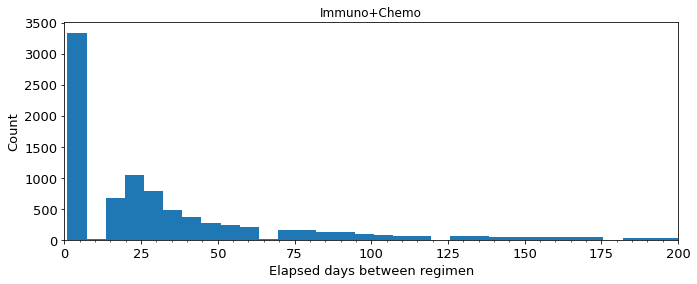

In [80]:
# regimen과 다음 regimen 사이의 간격 일수 ,
# 이것을 그려본 이유는 잘못된 regimen을 혹시 regimen_interval로 구분할 수 있는지 알고 싶어서
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
minorLocator   = AutoMinorLocator()
ax.hist(rgm_intervals, bins=500)
ax.set_xlim([0, 200])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('Elapsed days between regimen', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Immuno+Chemo')
ax.xaxis.set_minor_locator(minorLocator)
plt.show()

In [81]:
# regimen_drugtype_term_details: 각 샘플의 regimen을 하나의 row로 만듬 
# 환자에 regimen 개수에 따라서 row가 생성, regimen 2nd line까지 치료받은 환자는 2줄을 생성
display(regimen_drugtype_term_details)

,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,person_id,group
0,1,2010-01-07,2011-12-12,mage+as15,i,266,immuno
1,1,2010-01-07,2010-02-18,mage+as15,i,1459,immuno
2,2,2011-05-18,2011-07-21,"carboplatin,paclitaxel",cc,1459,immuno
3,3,2011-09-08,2011-09-15,gemciine,c,1459,immuno
4,1,2010-01-11,2010-12-15,mage+as15,i,1229,immuno
...,...,...,...,...,...,...,...
10009,1,2018-12-26,2018-12-26,"cisplatin,pemetrexed",cc,416,chemo
10010,1,2018-12-26,2018-12-26,"irinotecan_hcl,5-fluorouracil,leucovorin,oxaliplatin",cccc,2436,chemo
10011,1,2018-12-27,2018-12-31,"cisplatin,cetuximab,5-fluorouracil",ccc,858,chemo
10012,1,2018-12-31,2019-01-14,gefitinib,c,5327,chemo


In [82]:
# 이름이 길어서 짧은 이름으로 df를 만듦
rdtd = regimen_drugtype_term_details.copy()

In [83]:
rdtd.head()

,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,person_id,group
0,1,2010-01-07,2011-12-12,mage+as15,i,266,immuno
1,1,2010-01-07,2010-02-18,mage+as15,i,1459,immuno
2,2,2011-05-18,2011-07-21,"carboplatin,paclitaxel",cc,1459,immuno
3,3,2011-09-08,2011-09-15,gemciine,c,1459,immuno
4,1,2010-01-11,2010-12-15,mage+as15,i,1229,immuno


#### 관찰기간 정의 
1. obsterm1: 해당 Regimen의 약물투여기간
2. obsterm2: 해당 Regimen의 시작일부터 다음 Regimen의 시작 하루 전까지의 기간 
3. obsterm3: 해당 Regimen의 시작일부터 Last F/U까지 기간

In [84]:
drug_df.columns

Index(['drug_exposure_id', 'person_id', 'drug_concept_id',
       'drug_exposure_start_date', 'drug_exposure_start_datetime',
       'drug_exposure_end_date', 'drug_exposure_end_datetime',
       'verbatim_end_date', 'drug_type_concept_id', 'stop_reason', 'refills',
       'quantity', 'days_supply', 'sig', 'route_concept_id', 'lot_number',
       'provider_id', 'visit_occurrence_id', 'visit_detail_id',
       'drug_source_value', 'drug_source_concept_id', 'route_source_value',
       'dose_unit_source_value', 'code', 'name', 'isImmuno'],
      dtype='object')

In [85]:
for j, pid in enumerate(rdtd['person_id'].unique()) :
    
    k = 0
    obsterm_open = []
    obsterm1close = []
    obsterm2close = []
    obsterm3close = []
    pid_rdtd = rdtd[rdtd['person_id']==pid]
    pid_rdtd.reset_index(inplace=True)
    for k in range(pid_rdtd.shape[0]) :
        obsterm_open.append(pid_rdtd.loc[k, 'rgm_bgndate'])
        obsterm1close.append(pid_rdtd.loc[k, 'rgm_terdate'])
        obsterm3close.append(occurrence_pd[occurrence_pd['person_id']==pid]\
                                          .sort_values(by='visit_end_date', 
                                                       ascending=False)['visit_end_date'].values[0])
        if k + 1 < pid_rdtd.shape[0] :
            obsterm2close.append((pid_rdtd.loc[k+1, 'rgm_bgndate'] - pd.DateOffset(1)).date())
        else :
            obsterm2close.append(occurrence_pd[occurrence_pd['person_id']==pid]\
                                              .sort_values(by='visit_end_date', 
                                                           ascending=False)['visit_end_date'].values[0])
    pid_rdtd['obsterm_open'] = obsterm_open
    pid_rdtd['obsterm1close'] = obsterm1close
    pid_rdtd['obsterm2close'] = obsterm2close
    pid_rdtd['obsterm3close'] = obsterm3close
    if j == 0 :
        tmpdf = pid_rdtd.copy()
    else :
        tmpdf = pd.concat([tmpdf, pid_rdtd], ignore_index=True)
rdtd = tmpdf.copy()
display(rdtd.head())
rdtd.drop(columns=['index']).to_csv('regimen_identification_obsterm.csv', index=False)

,index,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,person_id,group,obsterm_open,obsterm1close,obsterm2close,obsterm3close
0,0,1,2010-01-07,2011-12-12,mage+as15,i,266,immuno,2010-01-07,2011-12-12,2018-09-10,2018-09-10
1,1,1,2010-01-07,2010-02-18,mage+as15,i,1459,immuno,2010-01-07,2010-02-18,2011-05-17,2011-09-29
2,2,2,2011-05-18,2011-07-21,"carboplatin,paclitaxel",cc,1459,immuno,2011-05-18,2011-07-21,2011-09-07,2011-09-29
3,3,3,2011-09-08,2011-09-15,gemciine,c,1459,immuno,2011-09-08,2011-09-15,2011-09-29,2011-09-29
4,4,1,2010-01-11,2010-12-15,mage+as15,i,1229,immuno,2010-01-11,2010-12-15,2015-08-17,2015-08-17


In [ ]:
pd.merge(rdtd.loc[:2, :], drug_df[['person_id', 'drug_exposure_start_date', 'drug_exposure_end_date', 
                                  'name']], 
         how ='left', left_on=['person_id', 'rgm_terdate'], right_on=['person_id', 'drug_exposure_start_date'])

In [ ]:
# # io 환자 중에 마지막 Regimen line io drug를 투약한 경우의 샘플번호, (마지막) regimen), 관찰기간(일)
# tmp = rdtd.groupby('person_id').agg({'regimen':np.max, 'drugtype':"+".join}).reset_index()
# tmp['last_drugtype'] = tmp['drugtype'].apply(lambda xs: xs.split("+")[-1])
# io_pid_last_regimen_df = tmp[tmp['last_drugtype'].str.contains('i')][['person_id', 'regimen']]
# io_last_regimen_terms = []
# for j, row in io_pid_last_regimen_df.iterrows() :
#     _last_obsterm = rdtd[(rdtd['person_id']==row['person_id']) & \
#                          (rdtd['regimen']==row['regimen'])]['obsterm_D'].values
   
#     io_last_regimen_terms.append(_last_obsterm[0])
# io_pid_last_regimen_df['last_obsterm_D'] = io_last_regimen_terms
# io_pid_last_regimen_df.head()

In [ ]:
# # chemo 환자 중에 마지막 Regimen line의 샘플번호, (마지막) regimen), 관찰기간(일)
# tmp = rdtd.groupby('person_id').agg({'regimen':np.max, 'drugtype':"+".join}).reset_index()
# tmp['last_drugtype'] = tmp['drugtype'].apply(lambda xs: xs.split("+")[-1])
# chemo_pid_last_regimen_df = tmp[tmp['last_drugtype'].str.contains('c')][['person_id', 'regimen']]
# chemo_last_regimen_terms = []
# for j, row in chemo_pid_last_regimen_df.iterrows() :
#     _last_obsterm = rdtd[(rdtd['person_id']==row['person_id']) & \
#                          (rdtd['regimen']==row['regimen'])]['obsterm_D'].values
   
#     chemo_last_regimen_terms.append(_last_obsterm[0])
# chemo_pid_last_regimen_df['last_obsterm_D'] = chemo_last_regimen_terms
# chemo_pid_last_regimen_df.head()

In [ ]:
# # io 환자의 각 regimen에서 관찰기간(일)의 히스토그램
# fig, ax = plt.subplots(2, 1, figsize=(13, 8))
# io_obs_terms = rdtd[rdtd['drugtype'].str.contains('i')]['obsterm_D'].values
# ax[0].hist(io_obs_terms/7, bins=50, label='N = '+str(len(io_obs_terms)))
# ax[0].set_yscale('log')
# ax[0].tick_params(axis='both', which='major', labelsize=15)
# ax[0].set_xlabel('Period of non-administration of drugs after begining of io-drug regimen (week)', fontsize=15)
# ax[0].set_ylabel('Count', fontsize=15)
# ax[0].set_title('Term btw the end of the regimen of io-drug and the start of the next regimen from io patients', 
#              fontsize=15)
# ax[0].xaxis.set_minor_locator(minorLocator)
# ax[0].legend(fontsize=15)

# # io 환자 중 마지막 regimen에서 io drug를 사램한 히스토그램
# ax[1].hist(np.asarray(io_last_regimen_terms)/7, bins=50, label='N = '+str(len(io_last_regimen_terms)))
# ax[1].set_yscale('log')
# ax[1].tick_params(axis='both', which='major', labelsize=15)
# ax[1].set_xlabel('Period of non-administration of drugs after begining of io-drug regimen (week)', fontsize=15)
# ax[1].set_ylabel('Count', fontsize=15)
# ax[1].set_title('Term btw the end date of the regimen of io-drug and the last visit date from io patients', 
#                 fontsize=15)
# ax[1].xaxis.set_minor_locator(minorLocator)
# ax[1].legend(fontsize=15)
# plt.tight_layout()
# plt.show()
# #display(len(io_obs_terms), len(io_last_regimen_terms))

In [ ]:
# cnt_io_last = 0
# cnt_chemo_last = 0
# iopid_last_rgm ={}
# for i, pid in enumerate(rdtd['person_id'].unique()) :
#     if rdtd[rdtd['person_id']==pid]['group'].unique()=='immuno' :
#         rgmlast = rdtd[rdtd['person_id']==pid]['regimen'].max()
#         druglast = rdtd[(rdtd['person_id']==pid) & (rdtd['regimen']==rgmlast)].loc[:, 'drugtype'].to_string()
#         if re.search(r'i', druglast) :
#             #print(rdtd[rdtd['person_id']==pid])
#             iopid_last_rgm[pid] = rgmlast
#             cnt_io_last+=1
#         else :
#             cnt_chemo_last += 1
# print('cnt_io_last', cnt_io_last)
# print('cnt_chemo_last', cnt_chemo_last)

In [ ]:
# vals = np.fromiter(iopid_last_rgm.values(), dtype=float)
# fig, ax = plt.subplots(1, 1, figsize=(11, 4))
# ax.hist(vals, bins=10)
# #ax.set_xlim([0, 200])
# ax.tick_params(axis='both', which='major', labelsize=13)
# ax.set_xlabel('Last regimen when io drug is used', fontsize=13)
# ax.set_ylabel('Count', fontsize=13)
# ax.set_title('Immuno')
# plt.show()

In [51]:
rdtd[rdtd['group']=='immuno']['person_id'].unique().shape

(1800,)

In [52]:
io_drugs = np.unique(drug_df[drug_df['isImmuno']==True]['name'].values)
io_drugs = set(io_drugs)
io_drugs

{'aldesleukin',
 'am0010',
 'atezolizumab',
 'avelumab',
 'bgb-a317',
 'bl-8040',
 'ca-170',
 'durvalumab',
 'epacadostat',
 'gdc-0919',
 'ipilimumab',
 'mage+as15',
 'mcs110',
 'medi4736',
 'medi5752',
 'medi5752_ivss',
 'medi9447',
 'mk-1308',
 'mk-3475',
 'mk-4280',
 'mk-7684',
 'moxr0916',
 'mpdl3280a',
 'msb0011359c',
 'mtig7192a',
 'nivolumab',
 'pdr001',
 'pembrolizumab',
 'pf-06801591',
 'regn2810',
 'regn3767',
 'ro6874281',
 'tremelimumab',
 'x4p-001'}

['mage+as15']
['mage+as15']
['mage+as15']
['mage+as15']
['mage+as15']
['mage+as15']
['mage+as15']
['mage+as15']
['aldesleukin']
['mage+as15']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['nivolumab']
['aldesleukin']
['aldesleukin']
['mage+as15']
['mage+as15']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['x4p-001']
['aldesleukin']
['nivolumab']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['nivolumab']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['mk-3475']
['mk-3475']
['aldesleukin']
['gdc-0919']
['aldesleukin']
['mk-3475']
['mk-3475']
['mk-3475']
['nivolumab']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['aldesleukin']
['mk-3475']
['mk-3475']
['aldesleukin']
['moxr0916']
['aldesleukin']
['mk-3475']
['nivolumab']
['nivolumab']
['ni

['pembrolizumab']
['nivolumab']
['atezolizumab']
['atezolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['nivolumab']
['mtig7192a']
['atezolizumab']
['pembrolizumab']
['nivolumab']
['nivolumab']
['durvalumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['nivolumab']
['atezolizumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['durvalumab']
['nivolumab']
['nivolumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['mtig7192a']
['nivolumab']
['nivolumab']
['atezolizumab']
['mk-3475']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['atezolizumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['regn2810']
['nivolumab']
['nivolumab']
['nivolumab']
['atezolizumab']
['mcs110']
['nivolumab']
['durvalumab']
['durvalumab']
['nivolumab']
['atezolizumab']
['nivolumab']
['du

['regn2810']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['avelumab']
['pembrolizumab']
['medi9447']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['regn2810']
['mk-7684']
['atezolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['nivolumab']
['atezolizumab']
['medi9447']
['pembrolizumab']
['am0010']
['nivolumab']
['nivolumab']
['pembrolizumab']
['mk-1308']
['pembrolizumab']
['nivolumab']
['nivolumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
['atezolizumab']
['nivolumab']
['atezolizumab']
['pembrolizumab']
['regn2810']
['avelumab']
['nivolumab']
['pembrolizumab']
['pembrolizumab']
['nivolumab']
['nivolumab']
['nivolumab']
['pembrolizumab']
['nivolumab']
['atezolizumab']
['pembrolizumab']
['nivolumab']
['pembrolizumab']
[

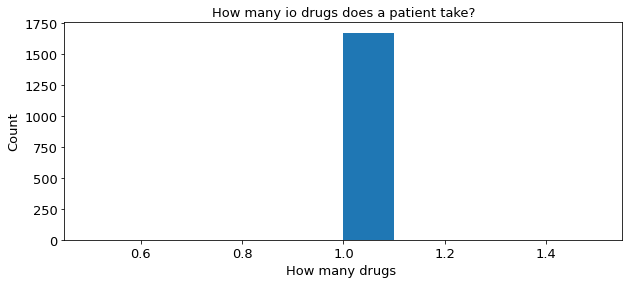

In [53]:
pid_io_dict = {}
cnt_immuno_iodrug = 0
for i, pid in enumerate(rdtd[rdtd['group']=='immuno']['person_id'].unique()) :
    pid_rgm = rdtd[(rdtd['person_id']==pid) & (rdtd['group']=='immuno')]
    drugtype_drugs = pid_rgm[pid_rgm['drugtype'].str.contains('i')]['drugs'].unique()
    pid_iodrug_set = set(",".join(drugtype_drugs).split(","))
#     print(pid_iodrug_set)
    for iodrug in pid_iodrug_set :
        io_drug_contains = []
        if iodrug in io_drugs :
            io_drug_contains.append(iodrug)
    if len(io_drug_contains) != 0  :
        print(io_drug_contains)
        pid_io_dict[pid] = io_drug_contains
n_iodurgs_pid = []
for key, value in pid_io_dict.items() :
    n_iodurgs_pid.append(len(value))                          
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(n_iodurgs_pid, bins=10)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('How many drugs ', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('How many io drugs does a patient take?', fontsize=13)
#ax.set_yscale('log')
plt.show()

In [54]:
len(pid_io_dict)

1672

In [55]:
display(personid_cancertypes_df.head())
display(person_pd.head())

,person_id,cancer_type,kcd,cancer_date,group
0,266,lung,C34,2010-01-07,immuno
1,1459,lung,C34,2010-01-07,immuno
2,1229,lung,C34,2010-01-11,immuno
3,1284,lung,C34,2010-01-11,immuno
4,1286,lung,C34,2010-01-19,immuno


,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,...,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,obfl,matchfl,one_on_two
0,16,8532,1952,2,NaN,NaT,38003585,0,NaN,NaN,...,None,Female,NaN,Korean,NaN,Not Hispanic or Latino,NaN,A,M1198,Y
1,17,8507,1945,7,NaN,NaT,38003585,0,NaN,NaN,...,None,Male,NaN,Korean,NaN,Not Hispanic or Latino,NaN,A,M0741,Y
2,25,8532,1949,2,NaN,NaT,38003585,0,NaN,NaN,...,None,Female,NaN,Korean,NaN,Not Hispanic or Latino,NaN,A,M0892,Y
3,18,8507,1934,12,NaN,NaT,38003585,0,NaN,NaN,...,None,Male,NaN,Korean,NaN,Not Hispanic or Latino,NaN,B,M0178,Y
4,20,8507,1940,10,NaN,NaT,38003585,0,NaN,NaN,...,None,Male,NaN,Korean,NaN,Not Hispanic or Latino,NaN,A,M0038,Y


In [56]:
person_sex_birth = person_pd[['person_id', 'year_of_birth', 'month_of_birth', 'gender_source_value']]
person_sex_birth['birthday'] = pd.to_datetime(person_pd['year_of_birth'].astype(str)+"/"+\
                                            person_pd['month_of_birth'].astype(str)+"/15")
person_sex_birth = person_sex_birth[['person_id', 'gender_source_value', 'birthday']]
person_sex_birth.columns= ['person_id', 'sex', 'birthday']

In [57]:
person_tmp = pd.merge(personid_cancertypes_df, regimen_df, how='inner', on=['person_id', 'group'])
person_total = pd.merge(person_sex_birth, person_tmp, how='right', on='person_id')
#person_total['birthday'] = pd.to_datetime(person_total['birthday'])
person_total['cancer_date'] = pd.to_datetime(person_total['cancer_date'])
person_total['age'] = (person_total['cancer_date'] - \
                                 person_total['birthday']).dt.days / 365.25
#display(person_total['last_regimen_line_bgndate'].dtype)
display(person_total)

,person_id,sex,birthday,cancer_type,kcd,cancer_date,group,last_regimen_line,last_regimen_line_bgndate,isCisMito,age
0,266,Male,1941-06-15,lung,C34,2010-01-07,immuno,1,2010-01-06,False,68.563997
1,1459,Male,1946-06-15,lung,C34,2010-01-07,immuno,3,2011-09-07,False,63.564682
2,1229,Male,1941-07-15,lung,C34,2010-01-11,immuno,1,2010-01-13,False,68.492813
3,1284,Male,1952-12-15,lung,C34,2010-01-11,immuno,1,2010-01-13,False,57.073238
4,1286,Male,1953-02-15,lung,C34,2010-01-19,immuno,1,2010-01-20,False,56.925394
...,...,...,...,...,...,...,...,...,...,...,...
5317,858,Female,1963-02-15,thyroid,C73,2010-05-24,chemo,1,2018-12-26,False,47.268994
5318,5303,Female,1958-02-15,uninary,C67,2018-11-14,chemo,0,2018-11-07 02:32:30,True,60.744695
5319,5246,Male,1957-12-15,biliary_pancreatic,C24,2018-08-24,chemo,0,2018-11-05,False,60.689938
5320,5327,Male,1958-08-15,lung,C34,2018-12-17,chemo,1,2019-01-02,False,60.339493


In [ ]:
# person_total[['person_id', 'sex', 'age', 'cancer_type', 
#               'kcd', 'group', 'last_regimen_line']].to_csv('study_sample.csv', index=False)

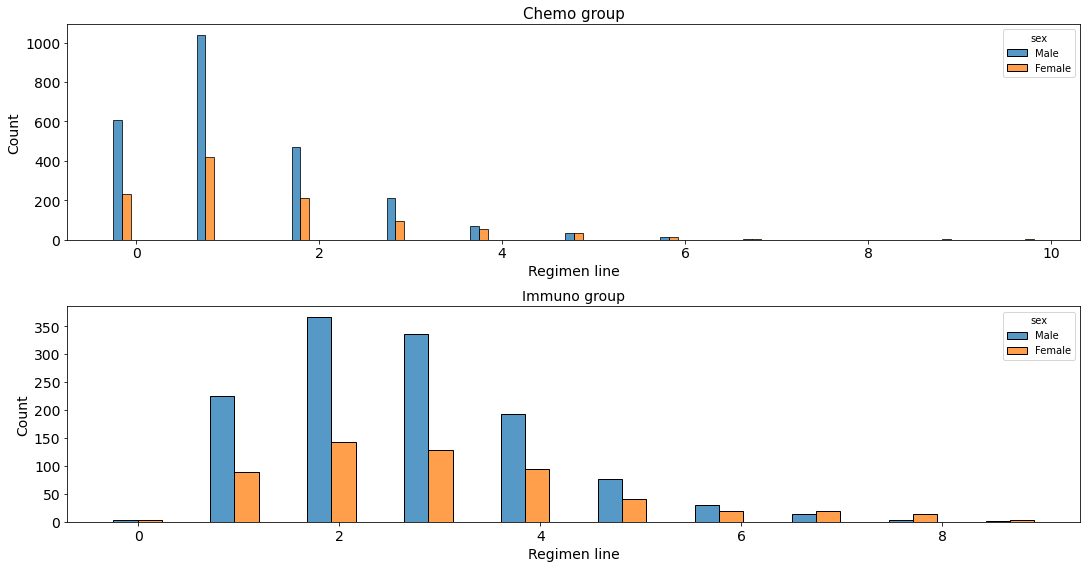

In [58]:
#sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(15.2, 8))
#ax = sns.catplot(x="sex", y="regimen_line", hue="group", kind="bar", data=person_total)
sns.histplot(data=person_total[person_total['group']=='chemo'], x="last_regimen_line", hue="sex", 
              multiple="dodge", shrink=1.5, ax=axs[0])
sns.histplot(data=person_total[person_total['group']=='immuno'], x="last_regimen_line", hue="sex", 
              multiple="dodge", shrink=1.5, ax=axs[1])
axs[0].set_title("Chemo group", fontsize=15)
axs[1].set_title("Immuno group", fontsize=14)
axs[0].set_xlabel("Regimen line", fontsize=14)
axs[1].set_xlabel("Regimen line", fontsize=14)
axs[0].set_ylabel("Count", fontsize=14)
axs[1].set_ylabel("Count", fontsize=14)
for i in range(0, 2) :
    for tick in axs[i].get_xticklabels():
        tick.set_fontsize(14)
    for tick in axs[i].get_yticklabels():
        tick.set_fontsize(14)
plt.tight_layout()

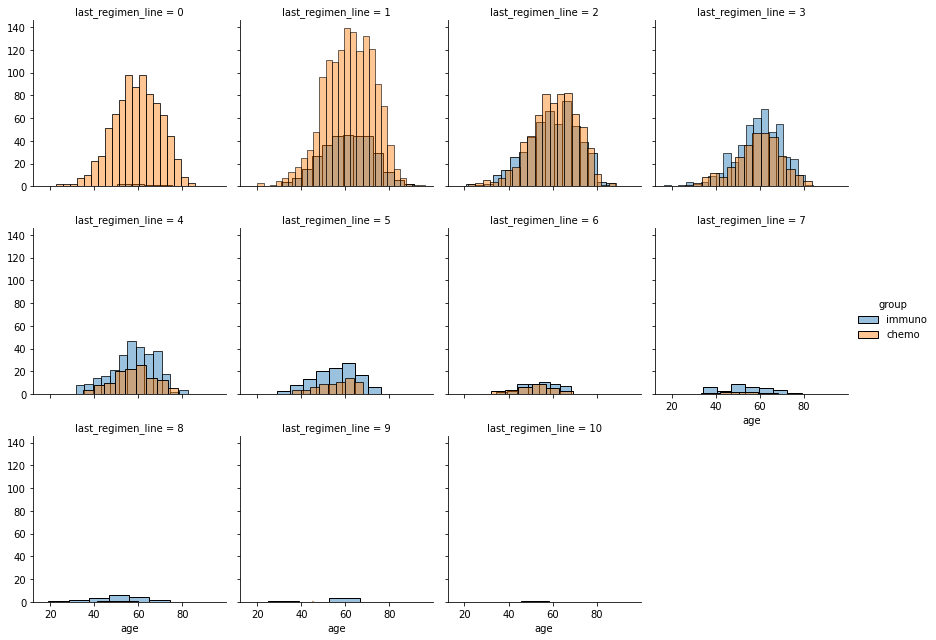

In [59]:
g = sns.FacetGrid(person_total, col="last_regimen_line", col_wrap=4, hue='group', 
                  margin_titles=True, legend_out=True)
g.map(sns.histplot, "age", alpha=0.45)
g.add_legend()

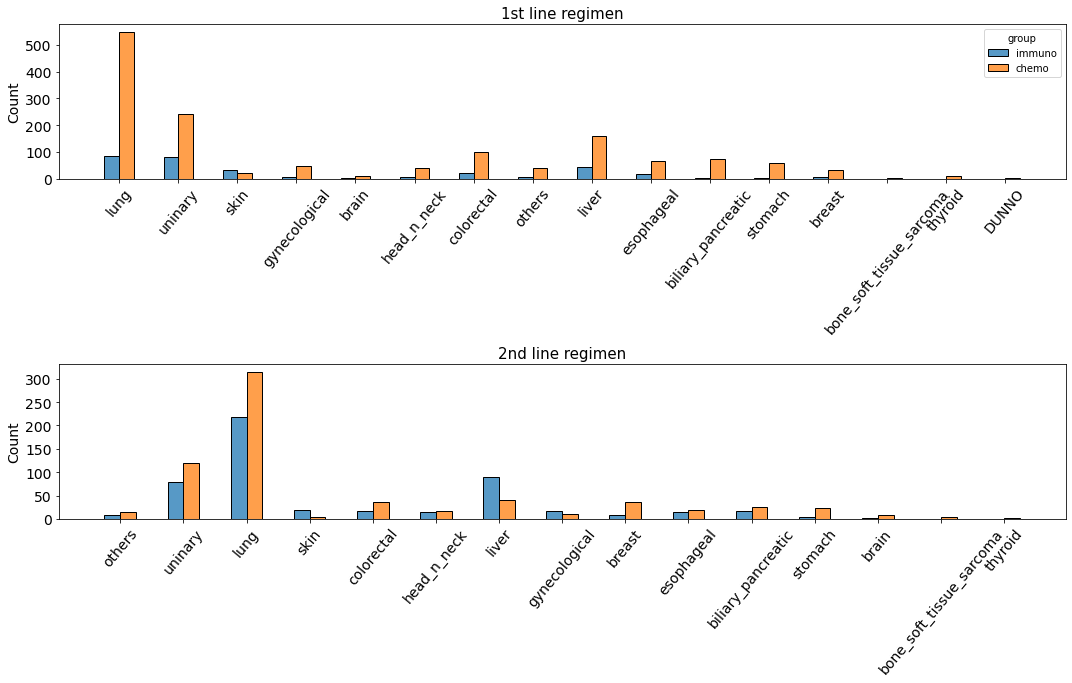

In [60]:
fig, axs = plt.subplots(2,1, figsize=(15, 9.6))

h1 = sns.histplot(data=person_total[person_total['last_regimen_line']==1], ax=axs[0],
                  x="cancer_type", hue="group", multiple="dodge", shrink=.5)
h2 = sns.histplot(data=person_total[person_total['last_regimen_line']==2], ax=axs[1], 
                  x="cancer_type", hue="group", multiple="dodge", shrink=.5, legend=False)
for i in range(0, 2) :
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(50)
        tick.set_fontsize(14)
    for tick in axs[i].get_yticklabels():
        tick.set_fontsize(14)
#print(axs[0].get_legend())
#plt.setp(axs[0].get_legend().get_texts(), fontsize='13')
axs[0].set_xlabel('', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[1].set_xlabel('', fontsize=14)
axs[1].set_ylabel('Count', fontsize=14)
axs[0].set_title('1st line regimen', fontsize=15)
axs[1].set_title('2nd line regimen', fontsize=15)
plt.tight_layout()

<AxesSubplot:xlabel='N_immuno_drug', ylabel='Count'>

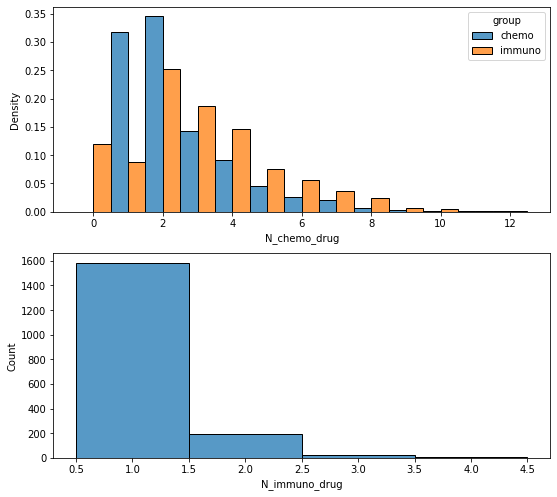

In [61]:
chemo_chemo_ndrugs = pd.read_csv("N_used_drug_chemo_chemo_group.txt", header=None)
chemo_chemo_ndrugs.drop_duplicates(inplace=True)
immuno_immuno_ndrugs = pd.read_csv("N_used_drug_immuno_immuno_group.txt", header=None)
chemo_immuno_ndrugs = pd.read_csv("N_used_drug_chemo_immuno_group.txt", header=None)
chemo_chemo_ndrugs.columns = ['pid', 'N_chemo_drug']
chemo_immuno_ndrugs.columns = ['pid', 'N_chemo_drug']
immuno_immuno_ndrugs.columns = ['pid', 'N_immuno_drug']
chemo_chemo_ndrugs['group'] = 'chemo'
# chemo_immuno_ndrugs['immunoTrue'] = True
# immuno_immuno_ndrugs['immunoTrue'] = True
immuno_group = pd.merge(chemo_immuno_ndrugs, immuno_immuno_ndrugs, on='pid')
immuno_group.drop_duplicates(inplace=True)
immuno_group['group'] = 'immuno'
ndrug = pd.concat([chemo_chemo_ndrugs, immuno_group])
#print(ndrug.sort_values(by='pid'))
# ndrugs.columns = ['pid', 'ndrug']
fig, ax = plt.subplots(2, 1, figsize=(8.9, 8.3))
sns.histplot(data=ndrug, x="N_chemo_drug", hue="group", binwidth=1, ax=ax[0], 
             stat='density', multiple='dodge', element='bars', 
             common_norm=False, discrete=True)
sns.histplot(data=ndrug, x="N_immuno_drug", bins=10, ax=ax[1], 
             stat='count', multiple='dodge', element='bars', 
             discrete=True)
# ndrugs['ndrug'].hist(bins=15, grid=True, color='tab:orange',
#                      xlabelsize=14, ylabelsize=14, 
#                      figsize=(8.9, 8.3), legend=False, ax=ax[0])
# ax.set_xlabel("Number of types of anti-cancer drugs prescribed by a patient", fontsize=14)
# ax.set_ylabel("Number of Patients", fontsize=14)
# #ax.set_title("Histogram of the types of anticancer drugs for the Chemo patient group", fontsize=14)
#ax[0].set_title("환자 1인에 사용한 화학항암제 종류 분포")
#ax[1].set_title("면역환자군의 환자 1인에 사용한 면역항암제 종류 분포")

In [62]:
# 첫번째 암선고를 기타암으로 받은 환자가 기타암이 아닌 다른 암종을 선고 받은 기록이 있을 경우 
# 며칠 후에 최초로 기타암이 아닌 암종을 선고받는지 계산 하였음
print(daygap_diag_2nd_nonothers_df.shape)
print(daygap_diag_2nd_nonothers_df[daygap_diag_2nd_nonothers_df['day_gap'].isnull()].shape)
daygap_diag_2nd_nonothers_df[daygap_diag_2nd_nonothers_df['day_gap'].notnull()]
bins = pd.IntervalIndex.from_tuples([(0, 31), (31, 92), (92, 365), (365, 3000)])
pd.cut(daygap_diag_2nd_nonothers_df[daygap_diag_2nd_nonothers_df['day_gap'].notnull()]['day_gap'], 
       bins, labels=["1mon", "1-3mon", "3-12m", ">1yr"]).value_counts()

(0, 2)
(0, 2)


(365, 3000]    0
(92, 365]      0
(31, 92]       0
(0, 31]        0
Name: day_gap, dtype: int64

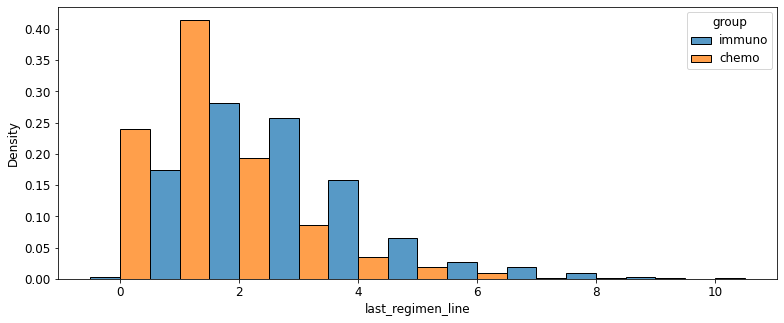

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12.9, 5))
sns.histplot(data=regimen_df, x="last_regimen_line", hue="group", binwidth=1, ax=ax, 
             stat='density', multiple='dodge', element='bars', 
             common_norm=False, discrete=True)
xlabel = ax.get_xlabel()
ylabel = ax.get_ylabel()
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
ax.tick_params(axis='both', labelsize=12)

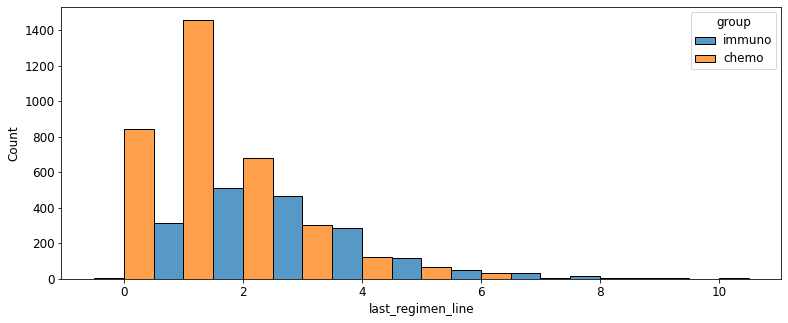

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12.9, 5))
sns.histplot(data=regimen_df, x="last_regimen_line", hue="group", binwidth=1, ax=ax, 
             stat='count', multiple='dodge', element='bars', 
             common_norm=False, discrete=True)
xlabel = ax.get_xlabel()
ylabel = ax.get_ylabel()
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
ax.tick_params(axis='both', labelsize=12)

In [65]:
regimen_df.to_csv("regimen_out.csv", index=False)
regimen_df.columns

Index(['person_id', 'last_regimen_line', 'group', 'last_regimen_line_bgndate',
       'isCisMito'],
      dtype='object')

In [66]:
# save immuno and regimen==0 and not cisplatin and mitomycin_c
save_path = 'immuno_regimen0_wo_CisMito'
os.makedirs(save_path, exist_ok=True)
png_heads = regimen_df[(regimen_df['last_regimen_line']==0) & 
          (regimen_df['group']=='immuno') & 
          (regimen_df['isCisMito']==False)]['person_id'].apply(lambda x: str(x).zfill(4)).values
print(len(png_heads))
for png_head in png_heads : 
    for dirpath, dirnames, filenames in os.walk("regimen_diagrams"):
        if png_head+'.png' in filenames :
            png_path = os.path.join(dirpath, png_head+'.png')
        if png_head+'.png' in dirnames :
            png_path = os.path.join(dirpath, png_head+'.png')
        try :
            shutil.copy(png_path, save_path)
        except NameError :
            print(png_head)

6
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676
3676


In [67]:
def matching_group(person_total, rdtd, ctype='kcd', agegap=1) :

    for j, row in rdtd[rdtd['drugtype'].str.contains('i')].iterrows() :
        io_individual = person_total[person_total['person_id'] == row['person_id']]
        io_individual['regimen'] = row['regimen']
        io_individual['rgm_bgndate'] = row['rgm_bgndate'] 
        io_individual['rgm_terdate'] = row['rgm_terdate']
        io_individual['drugs'] = row['drugs']
        io_individual['drugtype'] = row['drugtype']
        io_individual['obsterm_open'] = row['obsterm_open']
        io_individual['obsterm1close'] = row['obsterm1close']
        io_individual['obsterm2close'] = row['obsterm2close']
        io_individual['obsterm3close'] = row['obsterm3close']
        
        
        io_individual.drop(columns=['isCisMito'], inplace=True)
        chemo_candidate = person_total[person_total['group']=='chemo']
        chemo_pair = chemo_candidate[(chemo_candidate['sex']==io_individual['sex'].values[0]) &
                                     (chemo_candidate[ctype]==io_individual[ctype].values[0]) &
                                    (chemo_candidate['last_regimen_line']==row['regimen'])]
        chemo_pair['age_diff'] = chemo_pair['age'].apply(lambda x: x - io_individual['age'])
        chemo_pair = chemo_pair[chemo_pair['age_diff']<agegap]
        chemo_pair['regimen'] = row['regimen']
        chemo_pair = pd.merge(chemo_pair, rdtd, on=['person_id', 'regimen', 'group'], how='inner')
        chemo_pair.drop(columns = ['index', 'isCisMito'], inplace=True)
        if j == 0 and chemo_pair.shape[0] > 1 :
            control_any = chemo_pair.copy()
        else :
            if control_any.shape[0] < 1:
                control_any = chemo_pair.copy()
            else :
                control_any = pd.concat([control_any, chemo_pair], ignore_index=True)
        if j == 0 :
            treatment_any = io_individual.copy()
        else :
            treatment_any = pd.concat([treatment_any, io_individual], ignore_index=True)

    control_any.drop(columns=['age_diff'], inplace=True)
    control_any.drop_duplicates(inplace=True)
    return treatment_any, control_any

In [68]:
def comparison4plots(treatment, control, outname):
    
    data = pd.concat([treatment, control], ignore_index=True)
    fig = plt.figure(figsize=(15, 12))
    fig.patch.set_facecolor('white') 
    spec = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.3)
    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])
    ax3 = fig.add_subplot(spec[1, :])
    ax4 = fig.add_subplot(spec[2, :])
    
    sns.histplot(data=data, x="sex", hue='group', multiple="dodge", 
                 shrink=1, ax=ax1, legend=True) 
    sns.histplot(data=data, x="regimen", hue="group",  multiple="dodge", 
                 shrink=1, ax=ax2, legend=True) 
    sns.histplot(data=data, x="age", hue="group",  multiple="dodge", 
                 shrink=1, ax=ax3, legend=True) 
    sns.histplot(data=data, x="cancer_type", hue="group",  multiple="dodge", 
                 shrink=1, ax=ax4, legend=True) 
    
    for ax in [ax1, ax2, ax3, ax4] :
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
        if ax == ax4:
            for tick in ax.get_xticklabels():
                tick.set_rotation(50)
    plt.savefig(outname)

In [ ]:
# pair_cases = pd.DataFrame(columns=['ctype', 'agegaps', 'n_treatment', 'n_control'])
# for (ctype, agegap) in list(itertools.product(['kcd', 'cancer_type'], [1, 5, 10])) :
#     treat, control = matching_group(person_total, rdtd, ctype, agegap)
#     outname = 'type_'+ctype+'_'+'agegap_'+str(agegap)+'.png'
#     comparison4plots(treat, control, outname)
#     pair_cases.loc[len(pair_cases)] = [ctype, agegap, treat.shape[0], control.shape[0]]
# pair_cases.to_csv("treatment_control.csv", index=False)

#### 결국,  Immuno와 chemo를 그룹 매칭할 때 사용할 변수는 
- Age < 1
- Sex 
- Cancer type
- Regimen

Index(['person_id', 'sex', 'birthday', 'cancer_type', 'kcd', 'cancer_date',
       'group', 'last_regimen_line', 'last_regimen_line_bgndate', 'age',
       'regimen', 'rgm_bgndate', 'rgm_terdate', 'drugs', 'drugtype',
       'obsterm_open', 'obsterm1close', 'obsterm2close', 'obsterm3close'],
      dtype='object')
Index(['person_id', 'sex', 'birthday', 'cancer_type', 'kcd', 'cancer_date',
       'group', 'last_regimen_line', 'last_regimen_line_bgndate', 'age',
       'regimen', 'rgm_bgndate', 'rgm_terdate', 'drugs', 'drugtype',
       'obsterm_open', 'obsterm1close', 'obsterm2close', 'obsterm3close'],
      dtype='object')


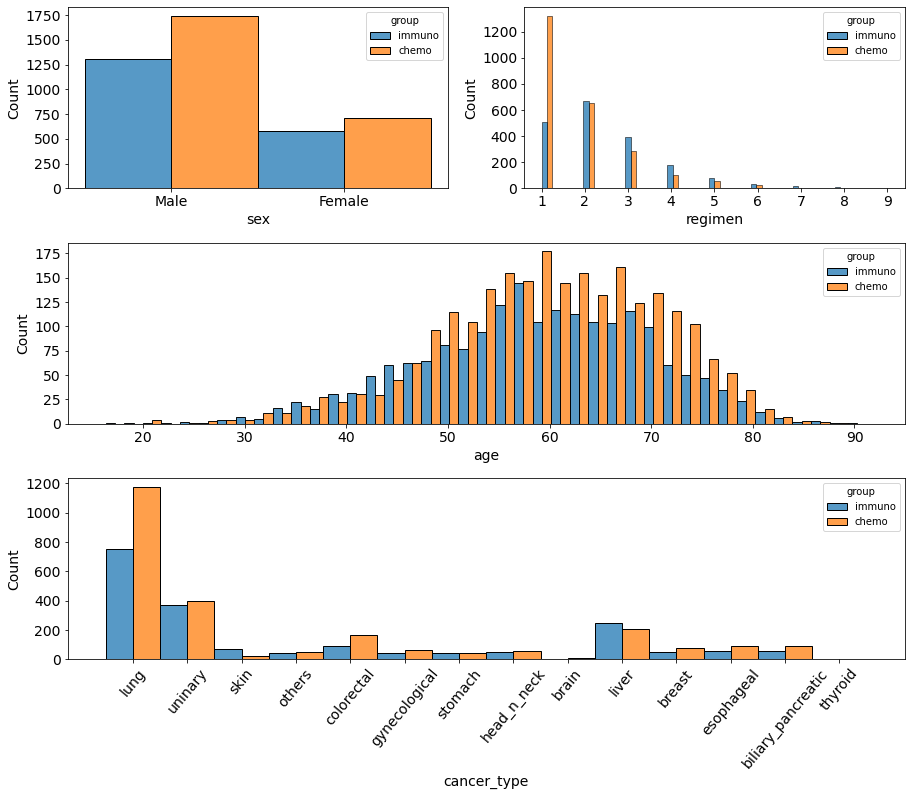

In [86]:
pairs = pd.DataFrame(columns=['ctype', 'agegaps', 'n_treatment', 'n_control'])
for (ctype, agegap) in list(itertools.product(['cancer_type'], [1])) :
    treat, control = matching_group(person_total, rdtd, ctype, agegap)
    print(treat.columns)
    print(control.columns)
    outname = 'type_'+ctype+'_'+'agegap_'+str(agegap)+'.png'
    comparison4plots(treat, control, outname)
    pairs.loc[len(pairs)] = [ctype, agegap, treat.shape[0], control.shape[0]]
pairs.to_csv("final_treatment_control_stats.csv", index=False)

In [96]:
rdtd[rdtd['person_id']==25]

,index,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,person_id,group,obsterm_open,obsterm1close,obsterm2close,obsterm3close
316,316,1,2015-02-12,2017-03-01,"medi4736,gefitinib",ic,25,immuno,2015-02-12,2017-03-01,2017-07-18,2018-04-12
317,317,2,2017-07-19,2017-11-27,yh25448,c,25,immuno,2017-07-19,2017-11-27,2018-04-12,2018-04-12


In [88]:
control[control['obsterm_open'].isnull()]

,person_id,sex,birthday,cancer_type,kcd,cancer_date,group,last_regimen_line,last_regimen_line_bgndate,age,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,obsterm_open,obsterm1close,obsterm2close,obsterm3close


In [89]:
display(treat.head())
display(control.head())
study_sample = pd.concat([treat, control], ignore_index=True)
study_sample.to_csv('sample_treatment_control.csv', index=False)

,person_id,sex,birthday,cancer_type,kcd,cancer_date,group,last_regimen_line,last_regimen_line_bgndate,age,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,obsterm_open,obsterm1close,obsterm2close,obsterm3close
0,266,Male,1941-06-15,lung,C34,2010-01-07,immuno,1,2010-01-06,68.563997,1.0,2010-01-07,2011-12-12,mage+as15,i,2010-01-07,2011-12-12,2018-09-10,2018-09-10
1,1459,Male,1946-06-15,lung,C34,2010-01-07,immuno,3,2011-09-07,63.564682,1.0,2010-01-07,2010-02-18,mage+as15,i,2010-01-07,2010-02-18,2011-05-17,2011-09-29
2,1229,Male,1941-07-15,lung,C34,2010-01-11,immuno,1,2010-01-13,68.492813,1.0,2010-01-11,2010-12-15,mage+as15,i,2010-01-11,2010-12-15,2015-08-17,2015-08-17
3,1284,Male,1952-12-15,lung,C34,2010-01-11,immuno,1,2010-01-13,57.073238,1.0,2010-01-11,2011-03-07,mage+as15,i,2010-01-11,2011-03-07,2014-05-26,2014-05-26
4,1286,Male,1953-02-15,lung,C34,2010-01-19,immuno,1,2010-01-20,56.925394,1.0,2010-01-19,2011-03-08,mage+as15,i,2010-01-19,2011-03-08,2018-03-13,2018-03-13


,person_id,sex,birthday,cancer_type,kcd,cancer_date,group,last_regimen_line,last_regimen_line_bgndate,age,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,obsterm_open,obsterm1close,obsterm2close,obsterm3close
0,441,Male,1947-11-15,lung,C34,2010-01-04,chemo,1,2010-01-06,62.138261,1,2010-01-04,2010-01-19,erlotinib,c,2010-01-04,2010-01-19,2010-02-08,2010-02-08
1,538,Male,1947-01-15,lung,C34,2010-01-04,chemo,1,2010-01-06,62.970568,1,2010-01-04,2010-03-11,erlotinib,c,2010-01-04,2010-03-11,2010-07-15,2010-07-15
2,1342,Male,1947-10-15,lung,C34,2010-01-04,chemo,1,2010-01-06,62.223135,1,2010-01-06,2010-02-03,belotecan,c,2010-01-06,2010-02-03,2010-05-12,2010-05-12
3,1415,Male,1940-06-15,lung,C34,2010-01-04,chemo,1,2010-01-06,69.555099,1,2010-01-06,2010-01-06,topotecan,c,2010-01-06,2010-01-06,2010-05-04,2010-05-04
4,967,Male,1947-02-15,lung,C34,2010-01-06,chemo,1,2010-01-06,62.891170,1,2010-01-06,2010-03-24,"cisplatin,gemciine",cc,2010-01-06,2010-03-24,2010-05-17,2010-05-17


In [90]:
study_sample.shape

(4347, 19)

In [91]:
study_sample[study_sample['last_regimen_line'] < study_sample['regimen']]

,person_id,sex,birthday,cancer_type,kcd,cancer_date,group,last_regimen_line,last_regimen_line_bgndate,age,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,obsterm_open,obsterm1close,obsterm2close,obsterm3close


In [92]:
study_sample[study_sample['obsterm_open'].isnull()]

,person_id,sex,birthday,cancer_type,kcd,cancer_date,group,last_regimen_line,last_regimen_line_bgndate,age,regimen,rgm_bgndate,rgm_terdate,drugs,drugtype,obsterm_open,obsterm1close,obsterm2close,obsterm3close


In [93]:
for col in study_sample.columns :
    print(study_sample[study_sample[col].isnull()])

Empty DataFrame
Columns: [person_id, sex, birthday, cancer_type, kcd, cancer_date, group, last_regimen_line, last_regimen_line_bgndate, age, regimen, rgm_bgndate, rgm_terdate, drugs, drugtype, obsterm_open, obsterm1close, obsterm2close, obsterm3close]
Index: []
Empty DataFrame
Columns: [person_id, sex, birthday, cancer_type, kcd, cancer_date, group, last_regimen_line, last_regimen_line_bgndate, age, regimen, rgm_bgndate, rgm_terdate, drugs, drugtype, obsterm_open, obsterm1close, obsterm2close, obsterm3close]
Index: []
Empty DataFrame
Columns: [person_id, sex, birthday, cancer_type, kcd, cancer_date, group, last_regimen_line, last_regimen_line_bgndate, age, regimen, rgm_bgndate, rgm_terdate, drugs, drugtype, obsterm_open, obsterm1close, obsterm2close, obsterm3close]
Index: []
Empty DataFrame
Columns: [person_id, sex, birthday, cancer_type, kcd, cancer_date, group, last_regimen_line, last_regimen_line_bgndate, age, regimen, rgm_bgndate, rgm_terdate, drugs, drugtype, obsterm_open, obsterm